## 1. About 

This notebook is used to generate graphcis for my bachelor thesis.

## 2. Code

### 2.1 Illustration SNN

In [1]:
import snntorch as snn
from snntorch import surrogate
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif"
})

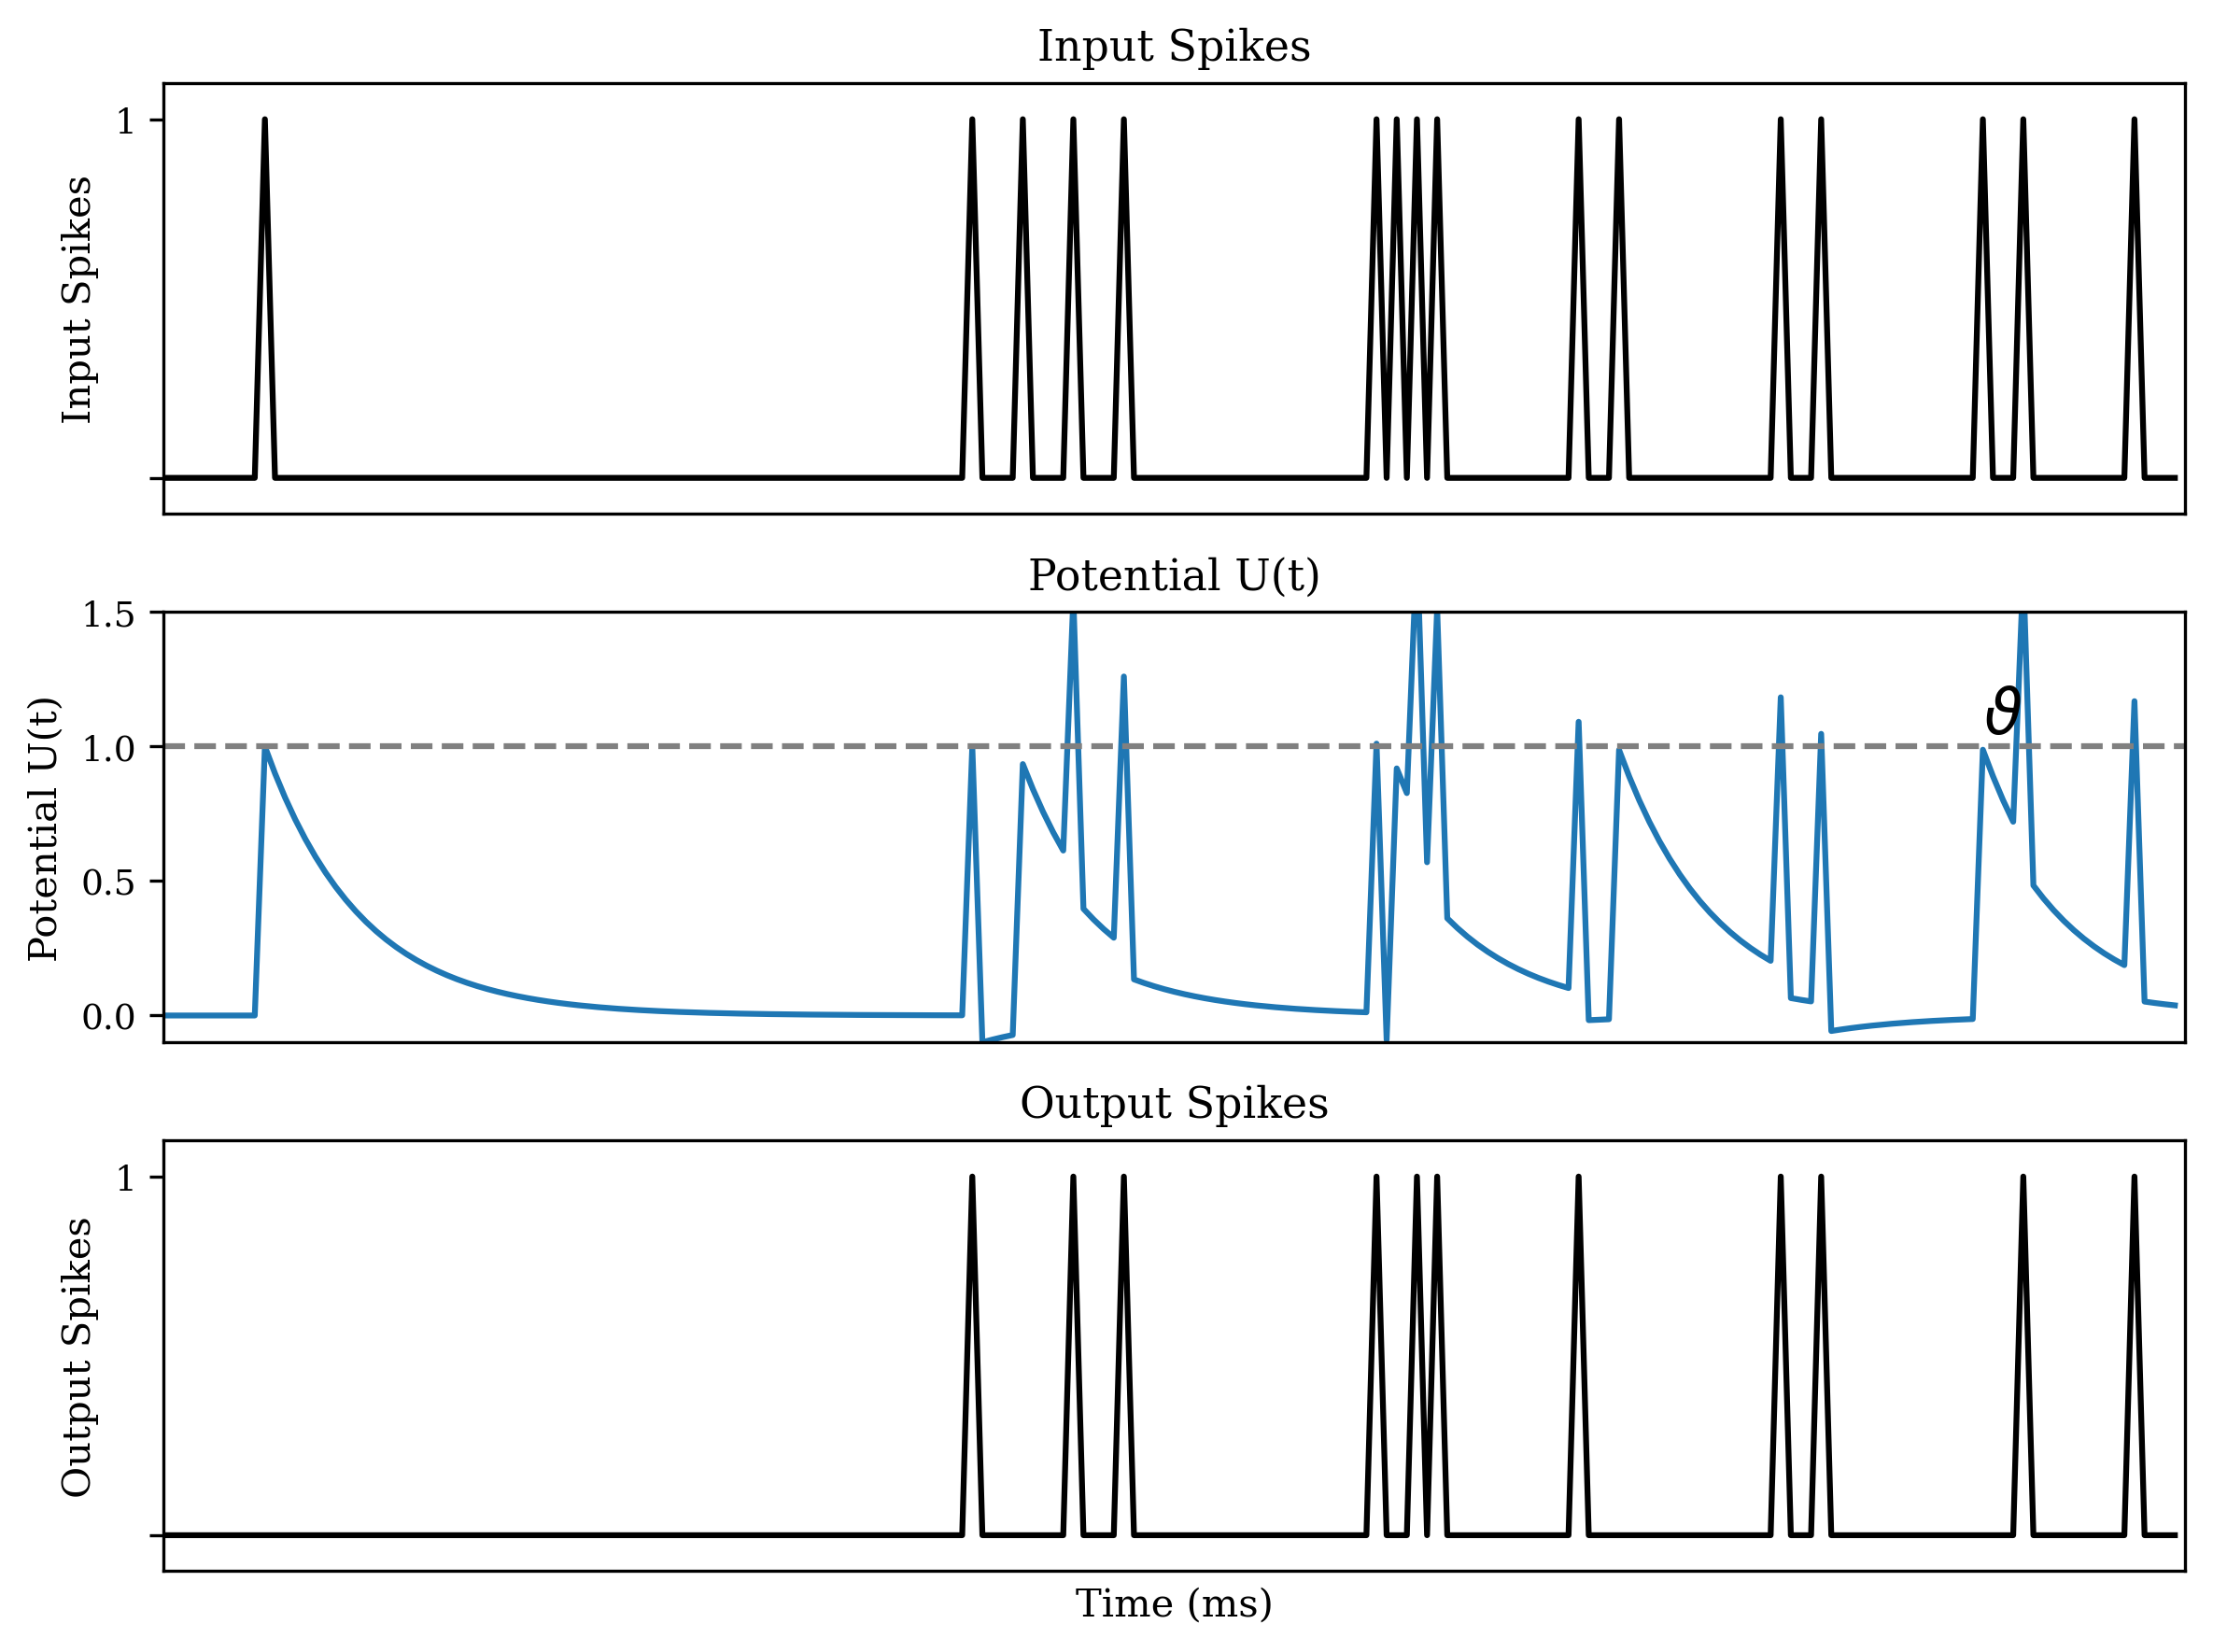

In [3]:
# Define simulation parameters
beta = 0.9  # membrane potential decay rate
threshold = 1  # neuron firing threshold
spike_grad = surrogate.atan()  # surrogate gradient for backpropagation
num_steps = 200  # simulation duration in time steps
input_size = 1 # Define input size explicitly

# Initialize LIF neuron
# Note: We remove init_hidden=True because we will manually manage the state
lif1 = snn.Leaky(beta=beta, threshold=threshold, spike_grad=spike_grad)

# Generate input spikes (similar to your image)
input_spikes = torch.zeros(num_steps, input_size)
input_spikes[10] = 1.0
input_spikes[80:100:5] = 1.0
input_spikes[120:128:2] = 1.0
input_spikes[140:148:4] = 1.0
input_spikes[160:168:4] = 1.0
input_spikes[180:188:4] = 1.0
input_spikes[195] = 1.0

# Store membrane potential and output spikes
mem_rec = []
spk_rec = []

# --- FIX: Initialize the internal states for the first step ---
mem = lif1.init_leaky() # Use the utility to initialize the membrane potential
spk = torch.zeros(input_size) # Initialize spike history (optional, but good practice)

# Simulate the neuron
for step in range(num_steps):
    # --- FIX: Pass the previous membrane potential (mem) as the second argument ---
    spk_out, mem_out = lif1(input_spikes[step].unsqueeze(0), mem)
    
    # Update the internal state for the next step
    mem = mem_out
    
    mem_rec.append(mem_out)
    spk_rec.append(spk_out)

# Convert lists to tensors
mem_rec = torch.stack(mem_rec).squeeze() # Squeeze to remove extra dimensions
spk_rec = torch.stack(spk_rec).squeeze()

# Plotting (Rest of your plotting code remains the same)
fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True)

# Input Spikes
ax[0].plot(input_spikes.squeeze().numpy(), color='black')
ax[0].set_title("Input Spikes")
ax[0].set_ylabel("Input Spikes")
ax[0].set_yticks([0, 1])
ax[0].set_yticklabels(['', '1'])
ax[0].set_xticks([])
ax[0].set_xlim([0, num_steps])
ax[0].set_ylim([-0.1, 1.1])

# Membrane Potential
ax[1].plot(mem_rec.numpy())
ax[1].axhline(y=threshold, linestyle='--', color='gray', label='Threshold')
ax[1].set_title("Potential U(t)")
ax[1].set_ylabel("Potential U(t)")
# Adjusted y-limits for better visibility
ax[1].set_ylim([-0.1, 1.5]) 
ax[1].text(num_steps - 20, threshold + 0.05, r'$\vartheta$', fontsize=16)

# Output Spikes
ax[2].plot(spk_rec.numpy(), color='black')
ax[2].set_title("Output Spikes")
ax[2].set_xlabel("Time (ms)")
ax[2].set_ylabel("Output Spikes")
ax[2].set_yticks([0, 1])
ax[2].set_yticklabels(['', '1'])
ax[2].set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()
plt.show()

fig.savefig("lif_simulation.png", bbox_inches="tight")

## 2.2 Visualize Decay of LeakyParallel

In [ ]:
firing_rate = 0.05  # spikes per timestep
input_spikes = torch.bernoulli(firing_rate*torch.ones(num_steps, input_size))

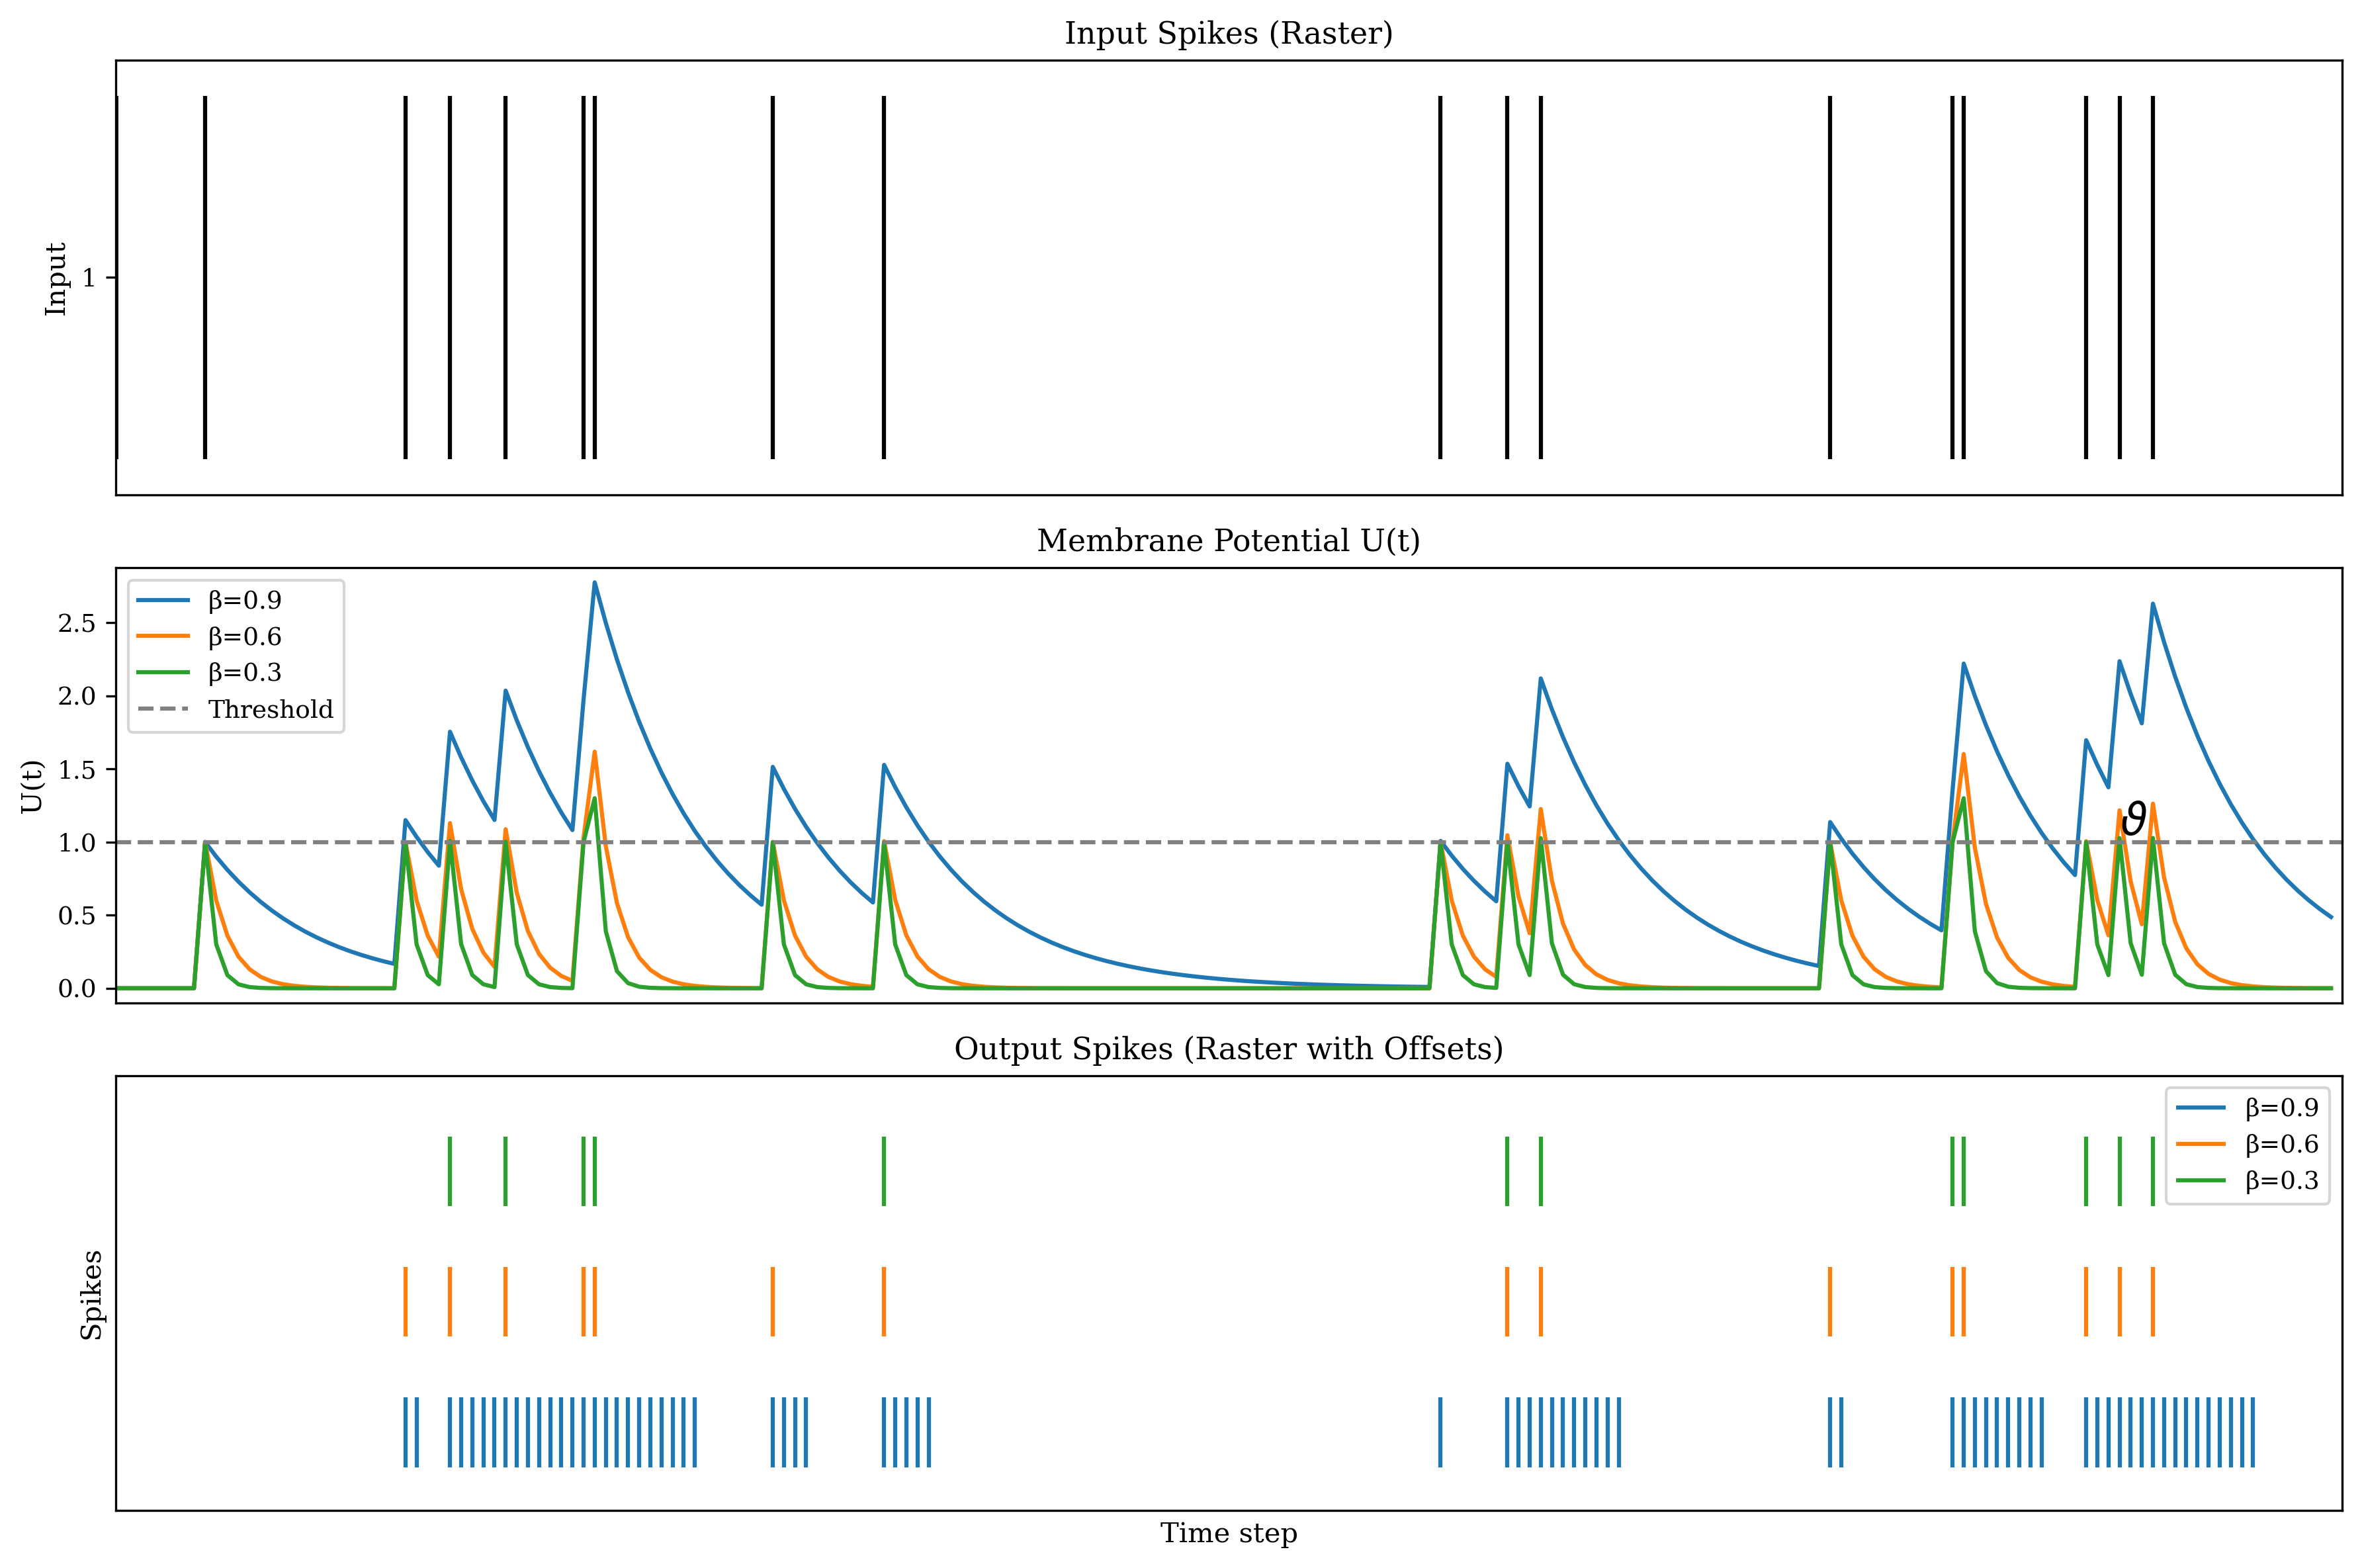

In [40]:
import torch
import matplotlib.pyplot as plt
import snntorch as snn
from snntorch import surrogate

# --- Simulation parameters ---
num_steps = 200
input_size = 1
threshold = 1.0
decays = [0.9, 0.6, 0.3]

# --- Generate input spikes ---
# Manual Spikes
input_spikes = torch.zeros(num_steps, input_size)
input_spikes[10] = 1.0
input_spikes[80:100:5] = 1.0
input_spikes[120:128:2] = 1.0
input_spikes[140:148:4] = 1.0
input_spikes[160:168:4] = 1.0
input_spikes[180:188:4] = 1.0
input_spikes[195] = 1.0

# Automatic spikes
firing_rate = 0.05  # spikes per timestep
input_spikes = torch.bernoulli(firing_rate*torch.ones(num_steps, input_size))


spike_grad = surrogate.atan()

# --- Run simulations ---
all_mem = {}
all_spikes = {}

for beta in decays:
    lif = snn.Leaky(
        beta=beta,
        threshold=threshold,
        spike_grad=spike_grad,
        reset_mechanism="none"
    )
    
    mem = lif.init_leaky()
    mem_rec = []
    spk_rec = []

    for step in range(num_steps):
        x = input_spikes[step].unsqueeze(0)
        spk, mem_out = lif(x, mem)
        mem = mem_out
        mem_rec.append(mem.clone())
        spk_rec.append(spk.clone())
        
    all_mem[beta] = torch.stack(mem_rec).squeeze()
    all_spikes[beta] = torch.stack(spk_rec).squeeze()

# --- Plotting ---
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# --- Input Spikes as raster ---
input_spike_times = input_spikes.nonzero().squeeze().numpy()
ax[0].vlines(input_spike_times, 0, 1, color='black')
ax[0].set_title("Input Spikes (Raster)")
ax[0].set_ylabel("Input")
ax[0].set_yticks([0.5])
ax[0].set_yticklabels(['1'])
ax[0].set_xlim([0, num_steps])
ax[0].set_ylim([-0.1, 1.1])
ax[0].set_xticks([])

# --- Membrane Potentials ---
for beta, mem_trace in all_mem.items():
    ax[1].plot(mem_trace.numpy(), label=f"β={beta}")
ax[1].axhline(y=threshold, linestyle='--', color='gray', label='Threshold')
ax[1].set_title("Membrane Potential U(t)")
ax[1].set_ylabel("U(t)")
ax[1].set_ylim([-0.1, max(v.max().item() for v in all_mem.values()) + 0.1])
ax[1].text(num_steps - 20, threshold + 0.05, r'$\vartheta$', fontsize=16)
ax[1].legend()

# --- Output Spikes with offsets ---
offset = 1.5
yticks = []
yticklabels = []

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, beta in enumerate(decays):
    spk_trace = all_spikes[beta]
    spike_times = spk_trace.nonzero().squeeze().numpy()
    y_base = i * offset
    ax[2].vlines(
        spike_times, 
        y_base, 
        y_base + 0.8, 
        color=colors[i % len(colors)],  # pick color from default cycle
        label=f"β={beta}"
    )


ax[2].set_title("Output Spikes (Raster with Offsets)")
ax[2].set_xlabel("Time step")
ax[2].set_ylabel("Spikes")
ax[2].set_yticks(yticks)
ax[2].set_yticklabels(yticklabels)
ax[2].set_ylim([-0.5, len(decays)*offset])
ax[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

fig.savefig("leakyParallel_simulation.pdf", bbox_inches="tight")

### 2.2 Loss Graphics

In [18]:
import wandb
import pandas as pd
import seaborn

In [19]:
wandb.login()

True

In [20]:
api = wandb.Api()

# Replace with your W&B entity/project
runs = api.runs("lupos/surrogate-confidence")

In [21]:
# Collect metrics from each run
data = []
for run in runs:
    summary = run.summary._json_dict
    config = {k: v for k, v in run.config.items() if not k.startswith('_')}
    name = run.name
    history = run.history(samples=10000)  # get all logged points
    history["run_name"] = name
    history["config"] = [config] * len(history)
    data.append(history)

df = pd.concat(data)

In [22]:
metric_cols = [
    c for c in df.columns
    # if not c.startswith(("gradients", "config", "_")) and "run_name" not in c
]
print(metric_cols)

['epoch', 'grad_mean/lif_layers.1', 'grad_mean/output_layer', '_runtime', '_step', 'val_loss', '_timestamp', 'spikes/train_avg_layer_1', 'spikes/train_avg_layer_2', 'grad_mean/lif_layers.3', 'lr', 'spikes/train_avg_layer_3', 'grad_mean/layer_norms', 'grad_mean/lif_layers.2', 'spikes/train_avg_layer_0', 'train_loss', 'trainer/global_step', 'grad_mean/lif_layers.0', 'run_name', 'config', 'grad_mean/lif_layers.4', 'grad_mean/lif_layers.5', 'spikes/train_avg_layer_5', 'grad_mean/lif_layers.6', 'grad_mean/lif_layers.7', 'spikes/train_avg_layer_6', 'spikes/train_avg_layer_4', 'spikes/train_avg_layer_7', 'grad_mean/layer_bntt', 'grad_mean/leaky_linears.2', 'grad_mean/leaky_linears.3', 'grad_mean/leaky_linears.0', 'grad_mean/leaky_linears.1', 'grad_mean/layer_bntt.3', 'grad_mean/layer_bntt.0', 'grad_mean/layer_bntt.2', 'grad_mean/layer_bntt.1', 'grad_mean/layer_norms.3', 'grad_mean/layer_norms.1', 'grad_mean/layer_norms.0', 'grad_mean/layer_norms.2', 'grad_mean/leaky_linears.6', 'grad_mean/lea

In [23]:
# Paper-friendly styling
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif"
})

NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Paper-friendly styling
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif"
})


include = ["GPT_Femto", "GPT_Nano", "RSNN_wHypOptim_4L"]
include = ["RSNN_wHypOptim_4L", "RSNN_wHypOptim_6L", "RSNN_wHypOptim_8L", "RSNN_wHypOptim_10L"]
include = ["RSNN_wHypOptim_4L", "RSNN_wHypOptim_Skip2", "RSNN_wHypOptim_Skip3", "RSNN_wHypOptim_Skip4"]
include = ["RSNN_wHypOpt", "RSNN_wHypOpt_Bntt", "RSNN_wHypOpt_LayNorm"]
include = ["RSNN_wLMSE", "RSNN_wLMAE", "RSNN_wLHuber"]
include = ["SLSTM_4L", "SLSTM_8L"]

window = 1  # smoothing window, bigger smoother

fig, ax = plt.subplots(figsize=(6, 4))

for model_name in include:
    # select all runs with this model name, checks if multiple exist when trained with seed
    group = df[df["run_name"].str.startswith(model_name + "_run")].dropna(subset=["trainer/global_step", "val_loss"])

    # Print summary of matched runs
    matched_runs = group["run_name"].unique()
    print(f"\nModel pattern: {model_name}")
    print(f"Matched runs ({len(matched_runs)}): {matched_runs}")
    print(f"Total rows in group: {len(group)}")
    
    if len(group) == 0:
        continue
    
    # Compute mean and std at each step
    stats = group.groupby("trainer/global_step")["val_loss"].agg(["mean", "std"])
    
    # Optional smoothing
    stats["mean"] = stats["mean"].rolling(window, min_periods=1).mean()
    
    # Plot mean line
    ax.plot(stats.index, stats["mean"], label=model_name, alpha=0.8)
    
    # Shaded ±1 std
    ax.fill_between(stats.index,
                    stats["mean"] - stats["std"],
                    stats["mean"] + stats["std"],
                    alpha=0.2)

# Labels, title, grid, legend
#ax.set_yscale("log") 
ax.set_xlabel("Steps")
ax.set_ylabel("Validation Loss")
ax.set_title("Validation Loss Across Runs")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(frameon=False)

plt.tight_layout()

# Save the figure
# fig.savefig("fully_trained_val_loss.png", bbox_inches="tight")
#fig.savefig("comparsion_normalization.png", bbox_inches="tight")
fig.savefig("comparsion_normalization.png", bbox_inches="tight")

plt.show()

### 2.3 Spiking Activity

/tmp/ipykernel_8381/119968616.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")


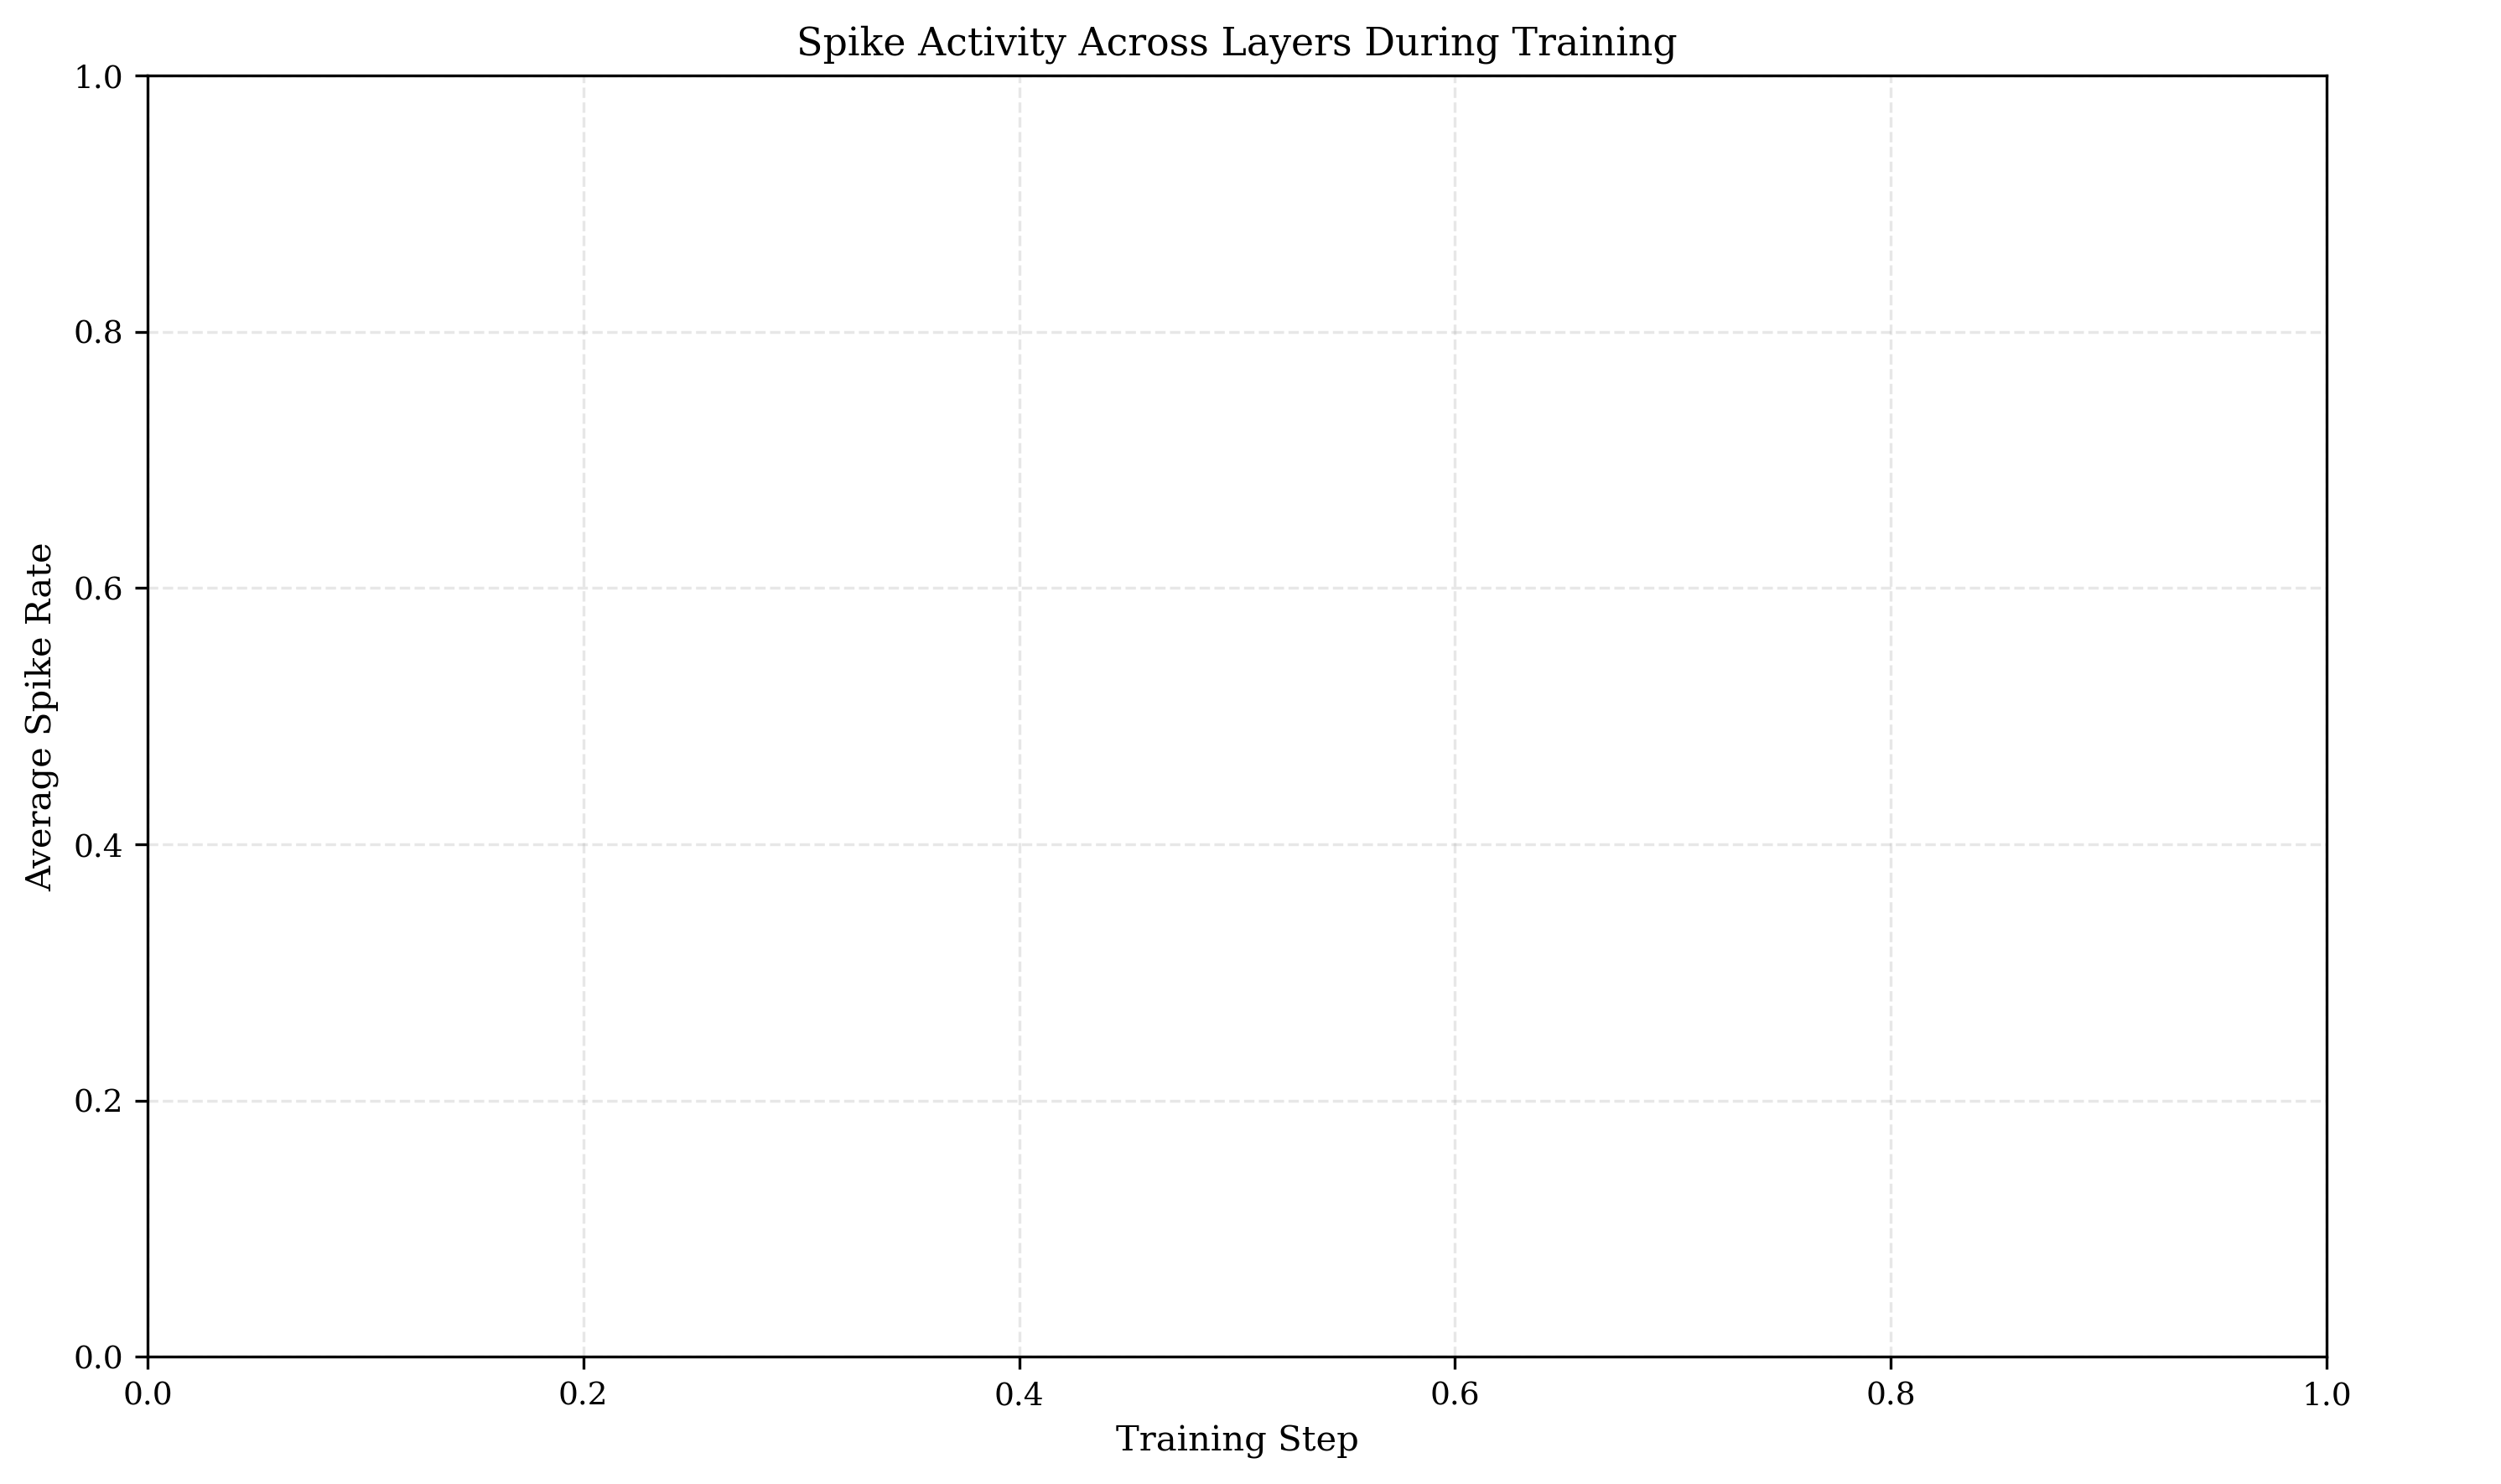

In [49]:
import matplotlib.pyplot as plt

spike_cols = sorted([c for c in df.columns if c.startswith("spikes/train_avg_layer")])
models = ["RSNN_wHypOptim_10L"]

plt.figure(figsize=(10, 6))

for model_name in models:
    group = df[df["run_name"] == model_name].dropna(subset=["trainer/global_step"] + spike_cols)
    if len(group) == 0:
        continue

    # Stack multiple runs if you have them (same run_name but different seeds)
    for col in spike_cols:
        # Compute mean and std across runs at each step
        stats = group.groupby("trainer/global_step")[col].agg(["mean", "std"])
        stats["mean"] = stats["mean"].rolling(window=3, min_periods=1).mean()
        
        plt.plot(stats.index, stats["mean"], label=f"{model_name} - {col}")
        plt.fill_between(stats.index, stats["mean"] - stats["std"], stats["mean"] + stats["std"], alpha=0.2)

plt.xlabel("Training Step")
plt.ylabel("Average Spike Rate")
plt.title("Spike Activity Across Layers During Training")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("spike_activity_layers_mean_std.pdf", bbox_inches="tight")
plt.show()


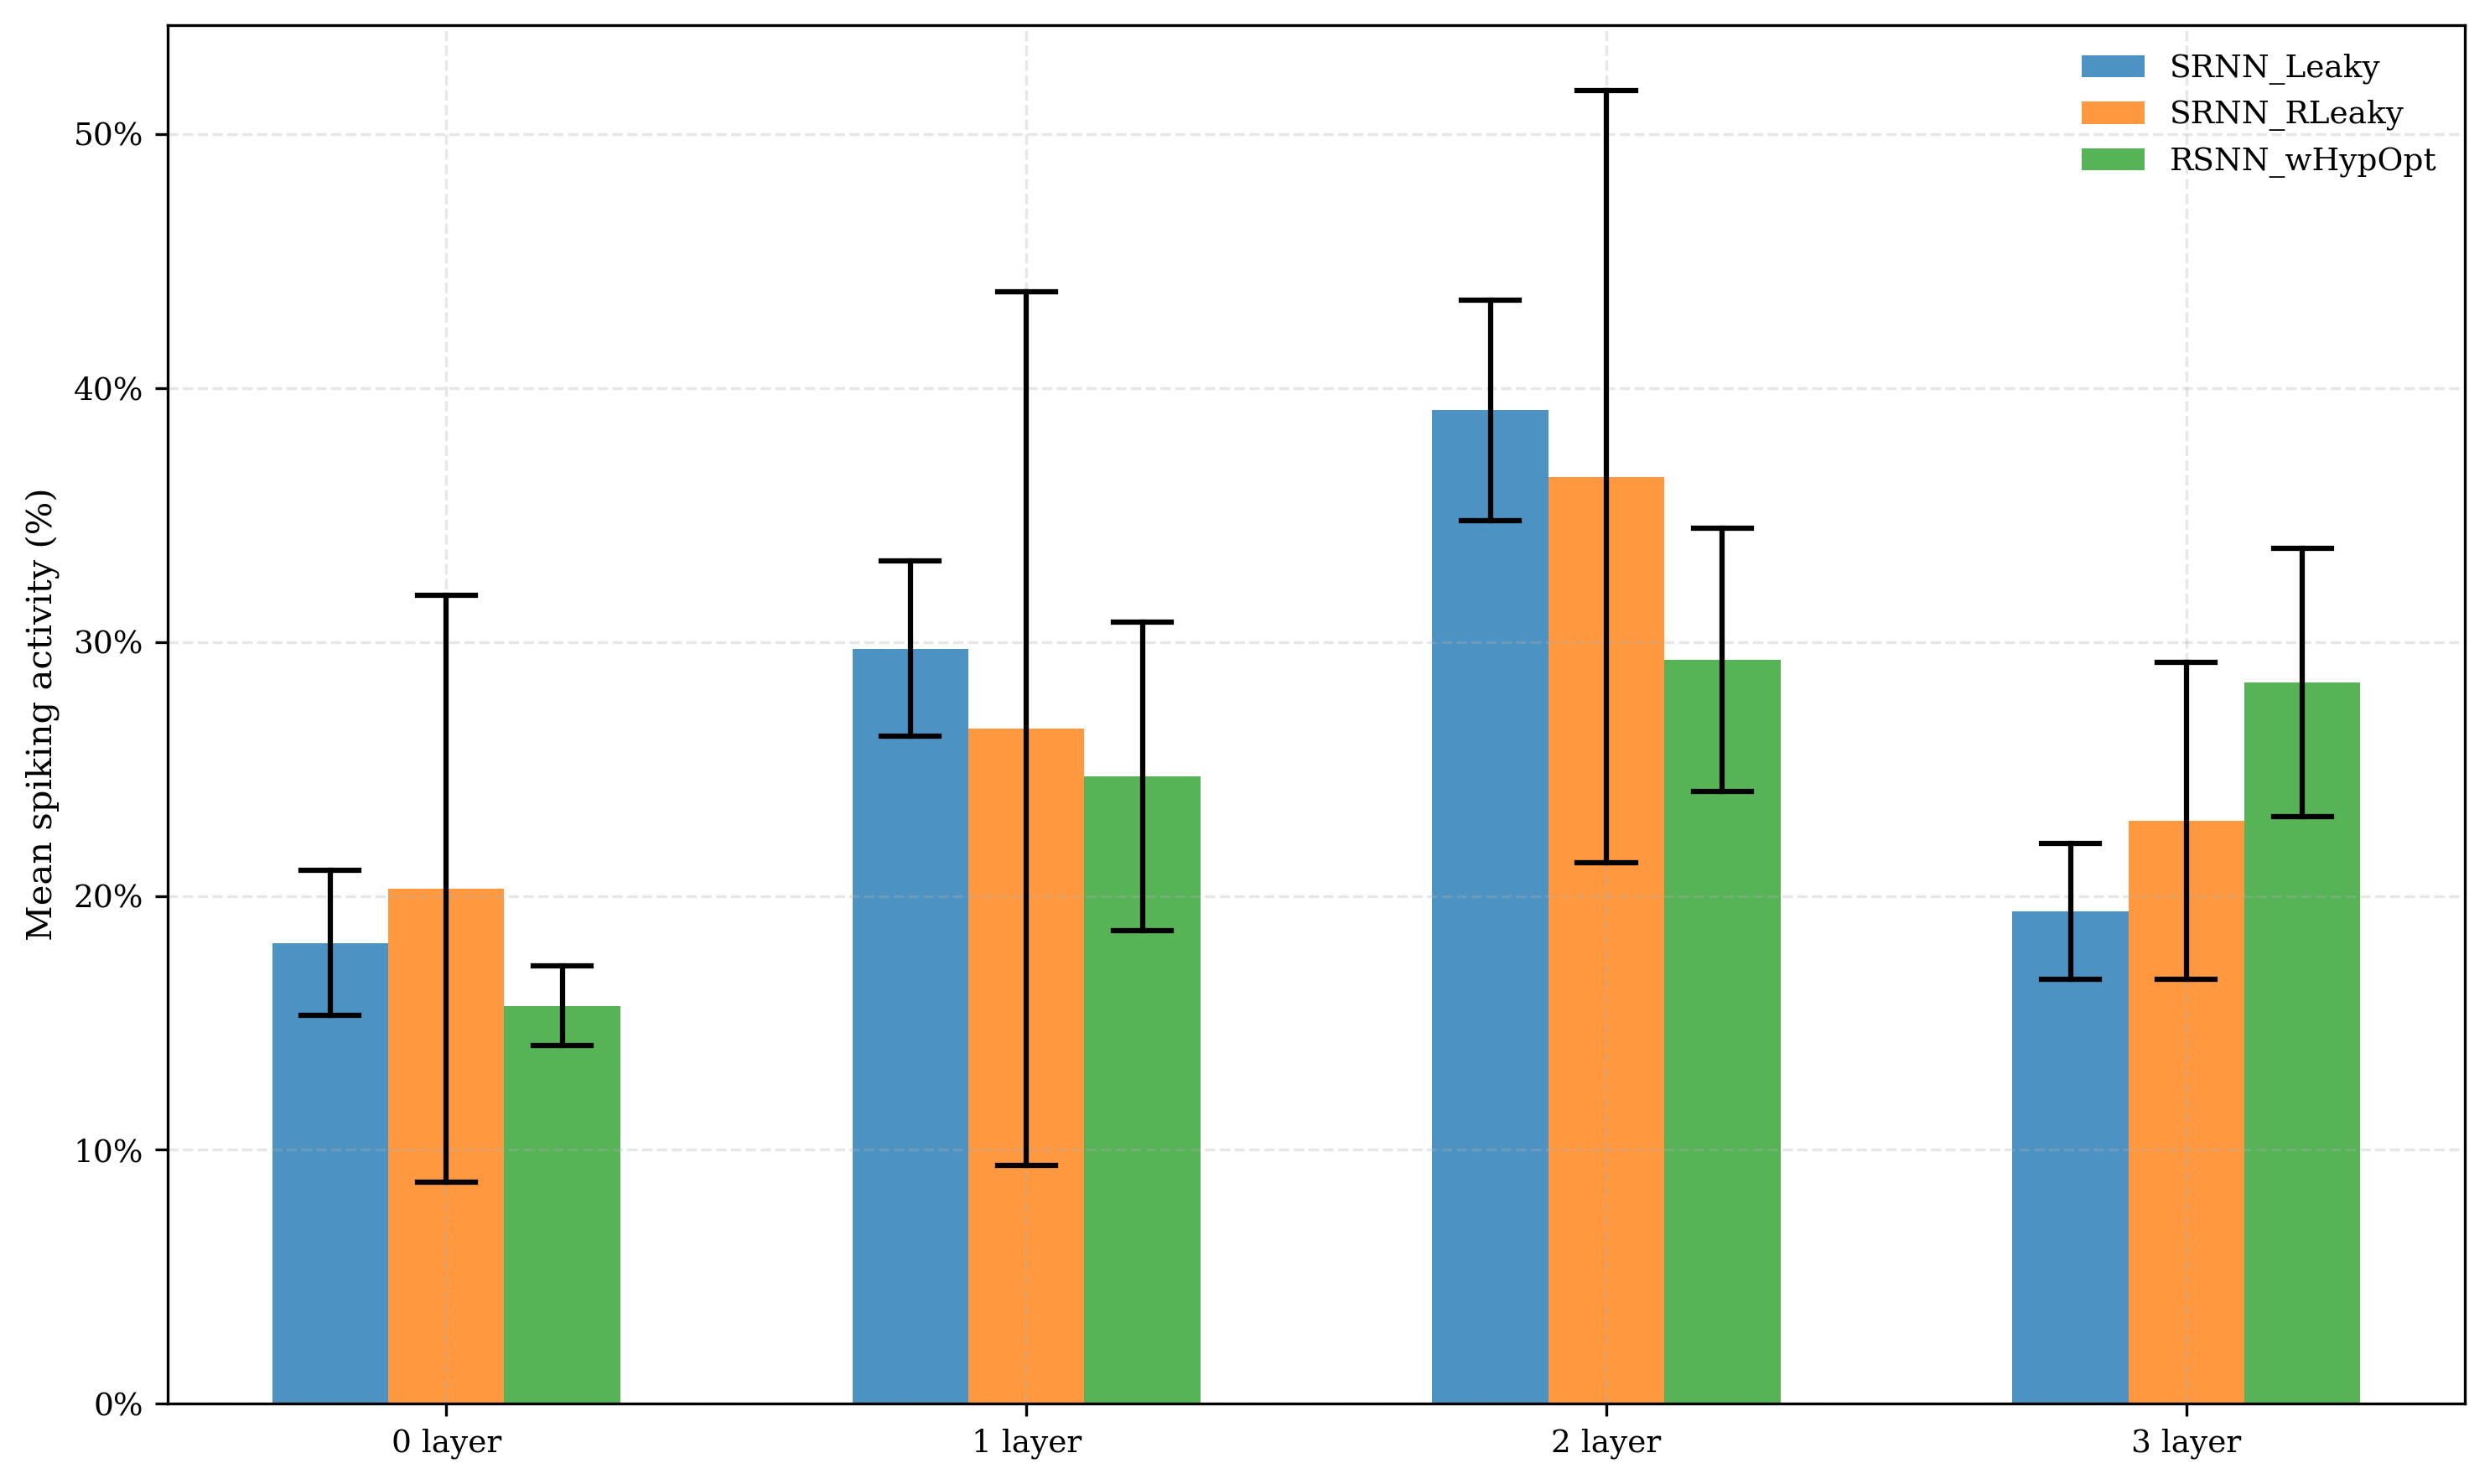

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.ticker import PercentFormatter

# Spike columns sorted by numeric layer index
spike_cols = sorted([c for c in df.columns if c.startswith("spikes/train_avg_layer_")],
                    key=lambda x: int(x.split("_")[-1]))

# Models (prefixes) to include
include = ["SRNN_Leaky", "SRNN_RLeaky", "RSNN_wHypOpt"]
# include = ["RSNN_wHypOpt", "RSNN_wHypOpt_Skip2", "RSNN_wHypOpt_Skip3"]
# include = ["RSNN_wHypOpt", "RSNN_wHypOptim_LayNorm", "RSNN_wHypOptim_BNTT"]


# All runs per model (assumes names end with _run1, _run2, etc.)
grouped_data = []
for model_prefix in include:
    pattern = re.compile(f"^{re.escape(model_prefix)}_run")
    group = df[df["run_name"].str.match(pattern)]
    if len(group) == 0:
        continue

    # Take the last row of each run
    last_steps = group.groupby("run_name").tail(1)
    
    # Compute mean and std across runs for each layer
    means = last_steps[spike_cols].mean()
    stds = last_steps[spike_cols].std()
    
    # Keep only layers with actual data
    valid_layers = means.notna()
    means = means[valid_layers]
    stds = stds[valid_layers]
    grouped_data.append((model_prefix, means, stds))

# Recompute layer indices based on layers that have data
layer_names = grouped_data[0][1].index  # assume all models have same layers
layer_indices = np.arange(len(layer_names))

# Plot
n_models = len(grouped_data)
width = 0.2  # width of each bar
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.get_cmap("tab10").colors
offset = -width*(n_models-1)/2

for i, (model_name, means, stds) in enumerate(grouped_data):
    positions = layer_indices + offset + i*width
    bars = ax.bar(positions, means.values, width=width, color=colors[i % len(colors)], alpha=0.8, label=model_name)
    
    # Add std as a line on top of the bar
    for x, m, s in zip(positions, means.values, stds.values):
        ax.plot([x, x], [m - s, m + s], color='black', lw=1.5)  # vertical line
        ax.plot([x - width/4, x + width/4], [m + s, m + s], color='black', lw=1.5)  # top cap
        ax.plot([x - width/4, x + width/4], [m - s, m - s], color='black', lw=1.5)  # bottom cap

# Set x-axis tick labels as "0 layer", "1 layer", etc.
ax.set_xticks(layer_indices)
ax.set_xticklabels([f"{c.split('_')[-1]} layer" for c in layer_names])

# Format y-axis as percentage
ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # assumes values are 0-1; use 100 if values are 0-100

ax.set_ylabel("Mean spiking activity (%)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig("spike_activity_different_neuron_types.pdf", bbox_inches="tight")
plt.show()

### 2.4 Gradients

In [69]:
print("grad_cols:", grad_cols)
print("available run_names:", df["run_name"].unique())
print(f"{model_name} - {col}: min={smooth_grad.min()}, max={smooth_grad.max()}")


grad_cols: ['grad_mean/layer_bntt', 'grad_mean/layer_norms', 'grad_mean/lif_layers.0', 'grad_mean/lif_layers.1', 'grad_mean/lif_layers.2', 'grad_mean/lif_layers.3', 'grad_mean/lif_layers.4', 'grad_mean/lif_layers.5', 'grad_mean/lif_layers.6', 'grad_mean/lif_layers.7', 'grad_mean/output_layer']
available run_names: ['SLSTM_8L_wLayNorm' 'RSNN_wHypOpt_LayNorm_run1'
 'RSNN_wHypOpt_LayNorm_run2' 'RSNN_wHypOpt_LayNorm_run3'
 'RSNN_wHypOpt_LayNorm_run4' 'SLSTM_4L_wLayNorm' 'RSNN_wHypOpt_run1'
 'SLSTM_8L_run1' 'SLSTM_4L_run1' 'RSNN_wHypOpt_Bntt_run1'
 'RSNN_wHypOpt_run2' 'SLSTM_4L_run2' 'RSNN_wHypOpt_run3'
 'RSNN_wHypOpt_run4' 'SLSTM_8L_run2']
SLSTM_8L - grad_mean/output_layer: min=0.0010376092395745218, max=0.06305664777755737


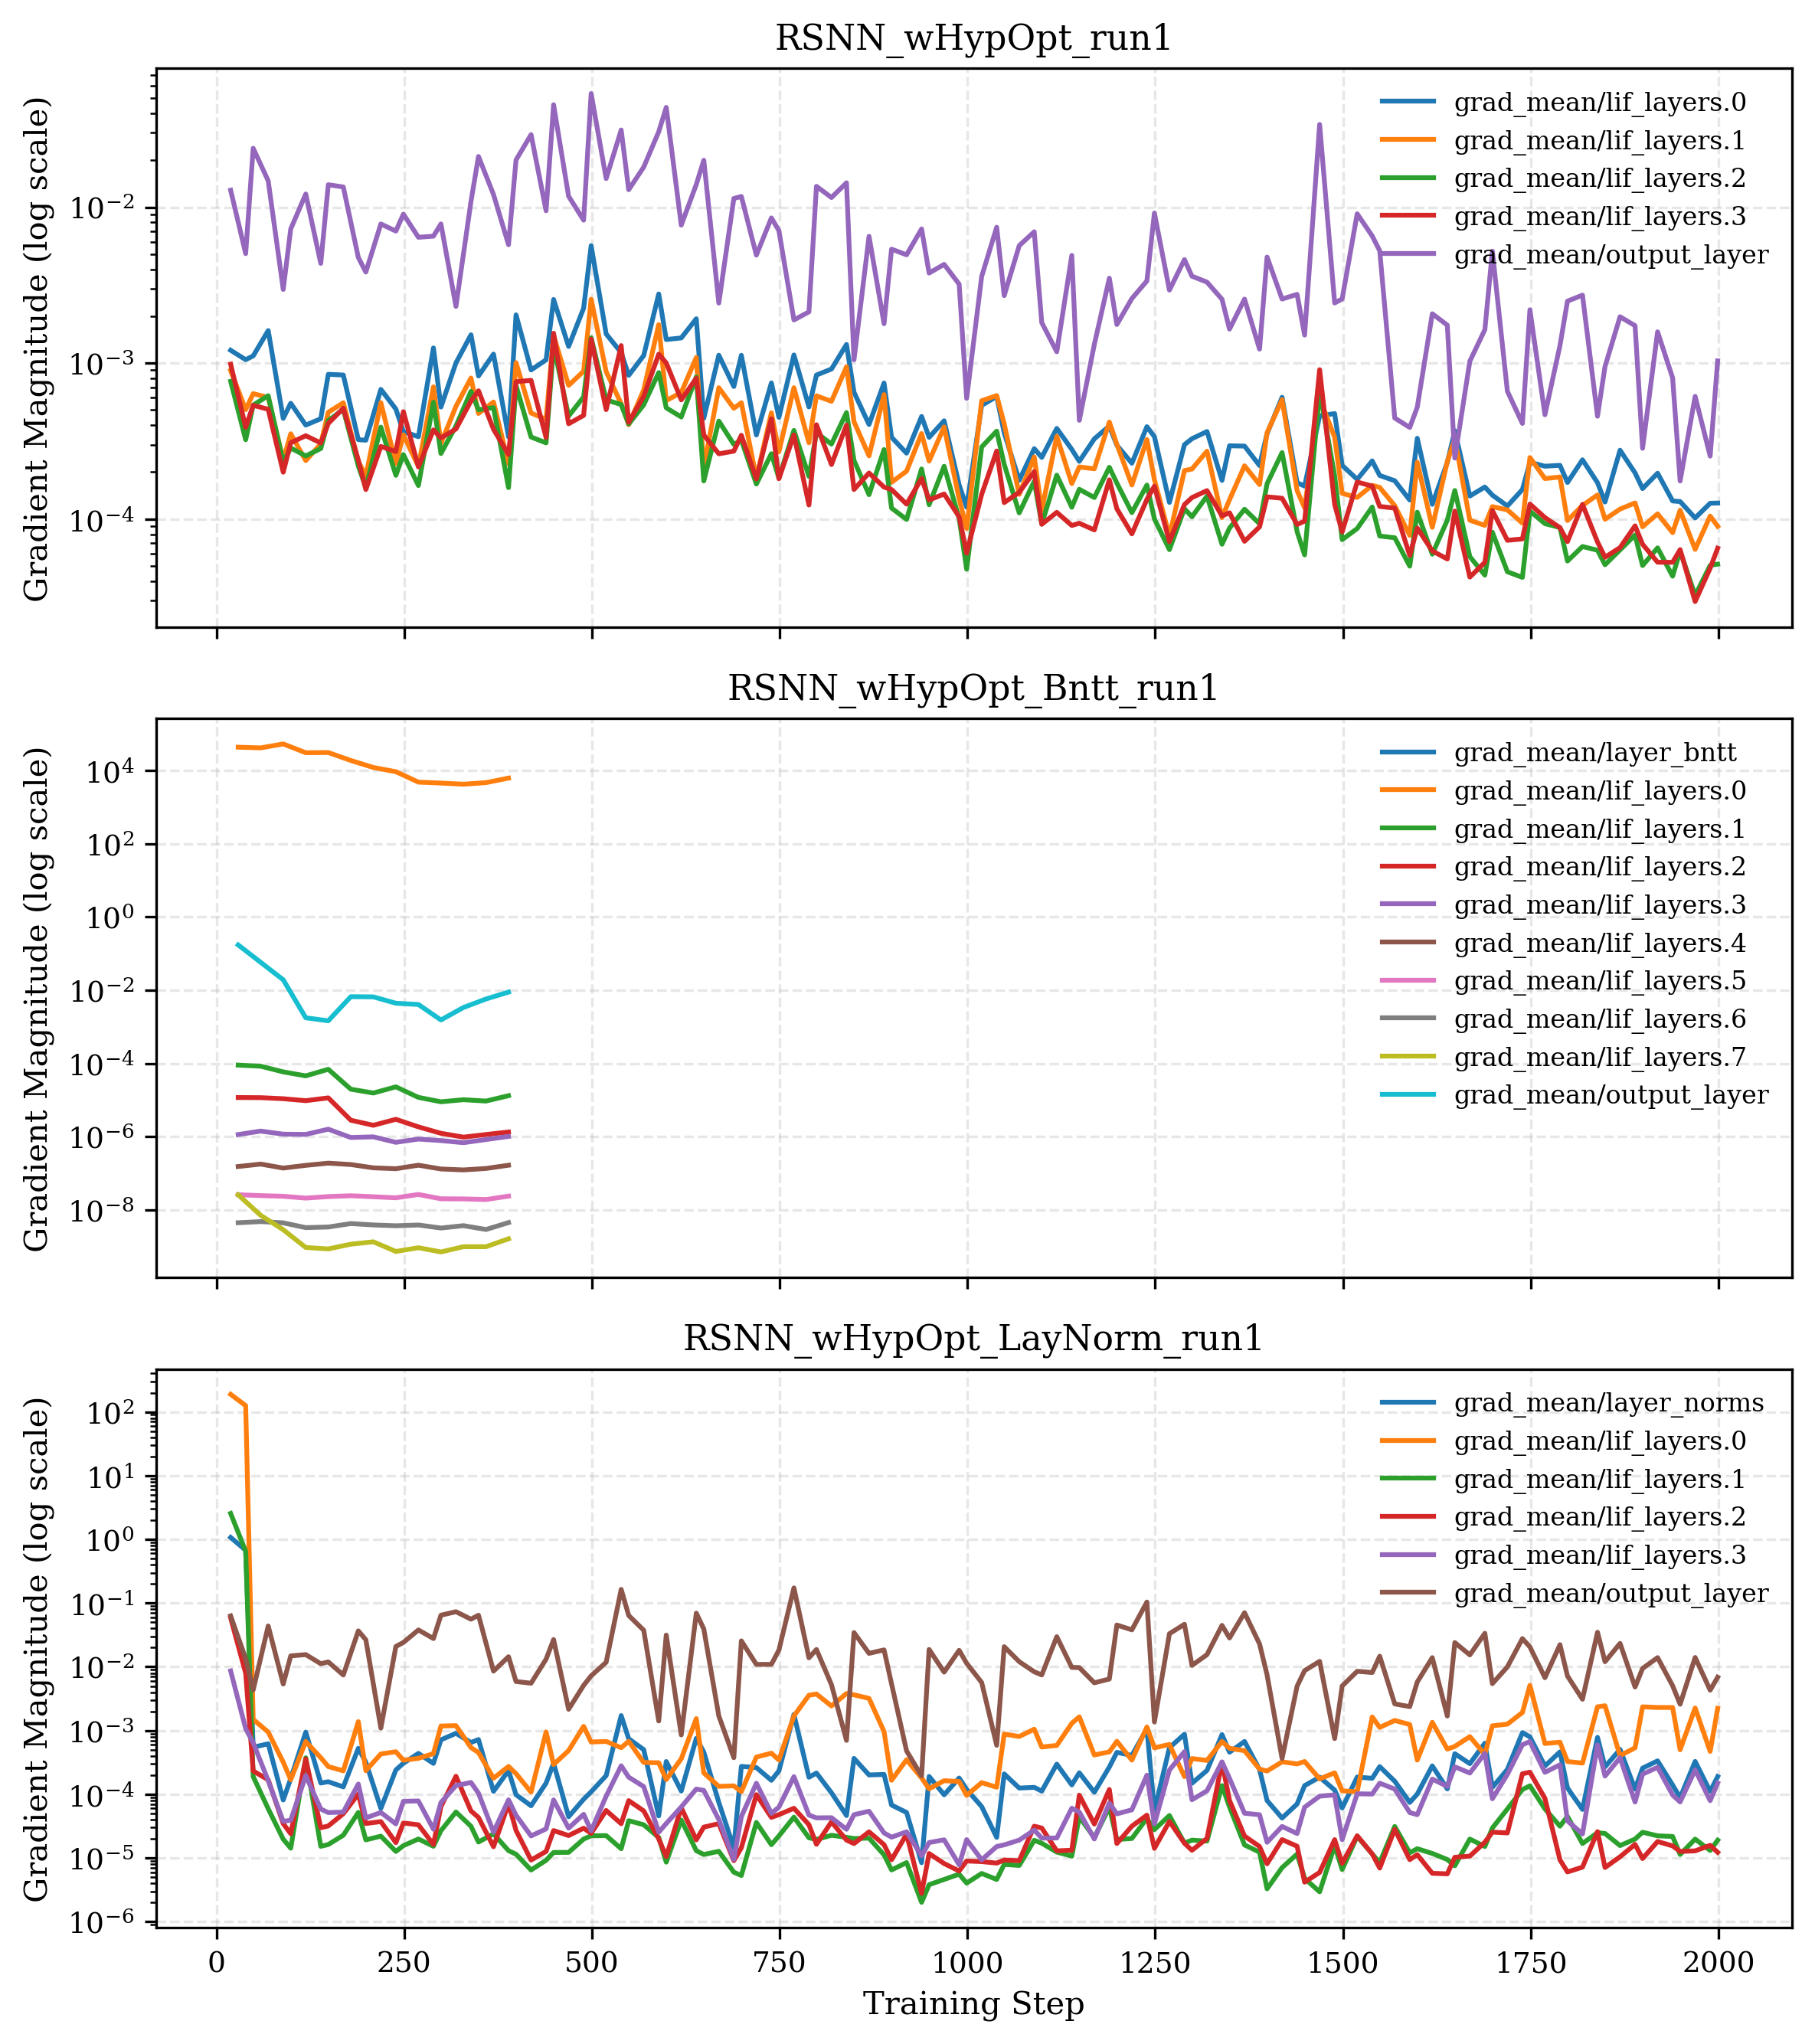

In [115]:
import matplotlib.pyplot as plt

grad_cols = sorted([c for c in df.columns if c.startswith("grad_mean/")])
include = ["SLSTM_4L_run1", "SLSTM_8L_run1"]
include = ["RSNN_wHypOpt_run1", "RSNN_wHypOpt_Bntt_run1", "RSNN_wHypOpt_LayNorm_run1"]
window = 0

fig, axes = plt.subplots(len(include), 1, figsize=(8, 3*len(include)), sharex=True)

if len(include) == 1:
    axes = [axes]

for ax, model_name in zip(axes, include):
    group = df[df["run_name"].str.startswith(model_name)].dropna(subset=["trainer/global_step"])
    if len(group) == 0:
        ax.set_title(f"{model_name} (no data)")
        continue

    for col in grad_cols:
        # skip if all NaN
        if group[col].notna().sum() == 0:
            continue

        # only keep rows where col has values
        data = group[["trainer/global_step", col]].copy()
        data = data[data[col].notna()]
        if len(data) == 0:
            continue

        # smooth if multiple points exist, otherwise just plot
        if len(data) > 1 and window > 1:
            smooth_grad = data[col].rolling(window=window, min_periods=1).mean()
        else:
            smooth_grad = data[col]

        ax.plot(data["trainer/global_step"], smooth_grad, label=col)

    ax.set_yscale("log")
    ax.set_title(model_name)
    ax.set_ylabel("Gradient Magnitude (log scale)")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(frameon=False, fontsize=8)

axes[-1].set_xlabel("Training Step")
plt.tight_layout()
plt.savefig("gradient_comparsion_normalization.pdf", bbox_inches="tight")
plt.show()

## 2.3 Hyperparmater Swep

### 2.3.1 First Step: Net Topology

In [49]:
import wandb
import pandas as pd
import seaborn
import polars as ps
import matplotlib.pyplot as plt

In [50]:
wandb.login()

True

In [51]:
api = wandb.Api()

# Replace with your W&B entity/project
entity = "lupos"
project = "SpikeSynth-Surrogate-Sweep"
sweep_id = "ol72k3cp"   

In [52]:
# Get the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

# Get all runs belonging to that sweep
runs = sweep.runs

# Collect run data
records = []
for run in sweep.runs:
    d = {
        "run_id": run.id,
        "name": run.name,
        "state": run.state,
        "summary": dict(run.summary),
    }
    # Flatten config into columns
    for k, v in run.config.items():
        if not k.startswith("_"):  # ignore internal W&B keys
            d[k] = v
    
    records.append(d)

# Create DataFrame
df1 = pd.DataFrame(records)

print(df1.head())

     run_id              name     state  \
0  4bj0rjpk  cerulean-sweep-1  finished   
1  s2qfzp4q    summer-sweep-2  finished   
2  oqjb8emv  cerulean-sweep-3  finished   
3  mhfawrv1     fresh-sweep-4  finished   
4  615z16d4     clean-sweep-5  finished   

                                             summary     lr  beta  alpha  \
0  {'_runtime': 133, '_step': 82, '_timestamp': 1...  0.005   0.8      8   
1  {'_runtime': 32, '_step': 82, '_timestamp': 17...  0.005   0.8      4   
2  {'_runtime': 1633, '_step': 82, '_timestamp': ...  0.005   0.5      8   
3  {'_runtime': 489, '_step': 82, '_timestamp': 1...  0.005   0.5      4   
4  {'_runtime': 33, '_step': 82, '_timestamp': 17...  0.005   0.5      6   

   epochs  dropout  use_bntt  ... num_hidden  temporal_skip  use_layernorm  \
0      40        0     False  ...         32             -1          False   
1      40        0     False  ...          4             -1          False   
2      40        0     False  ...        128      

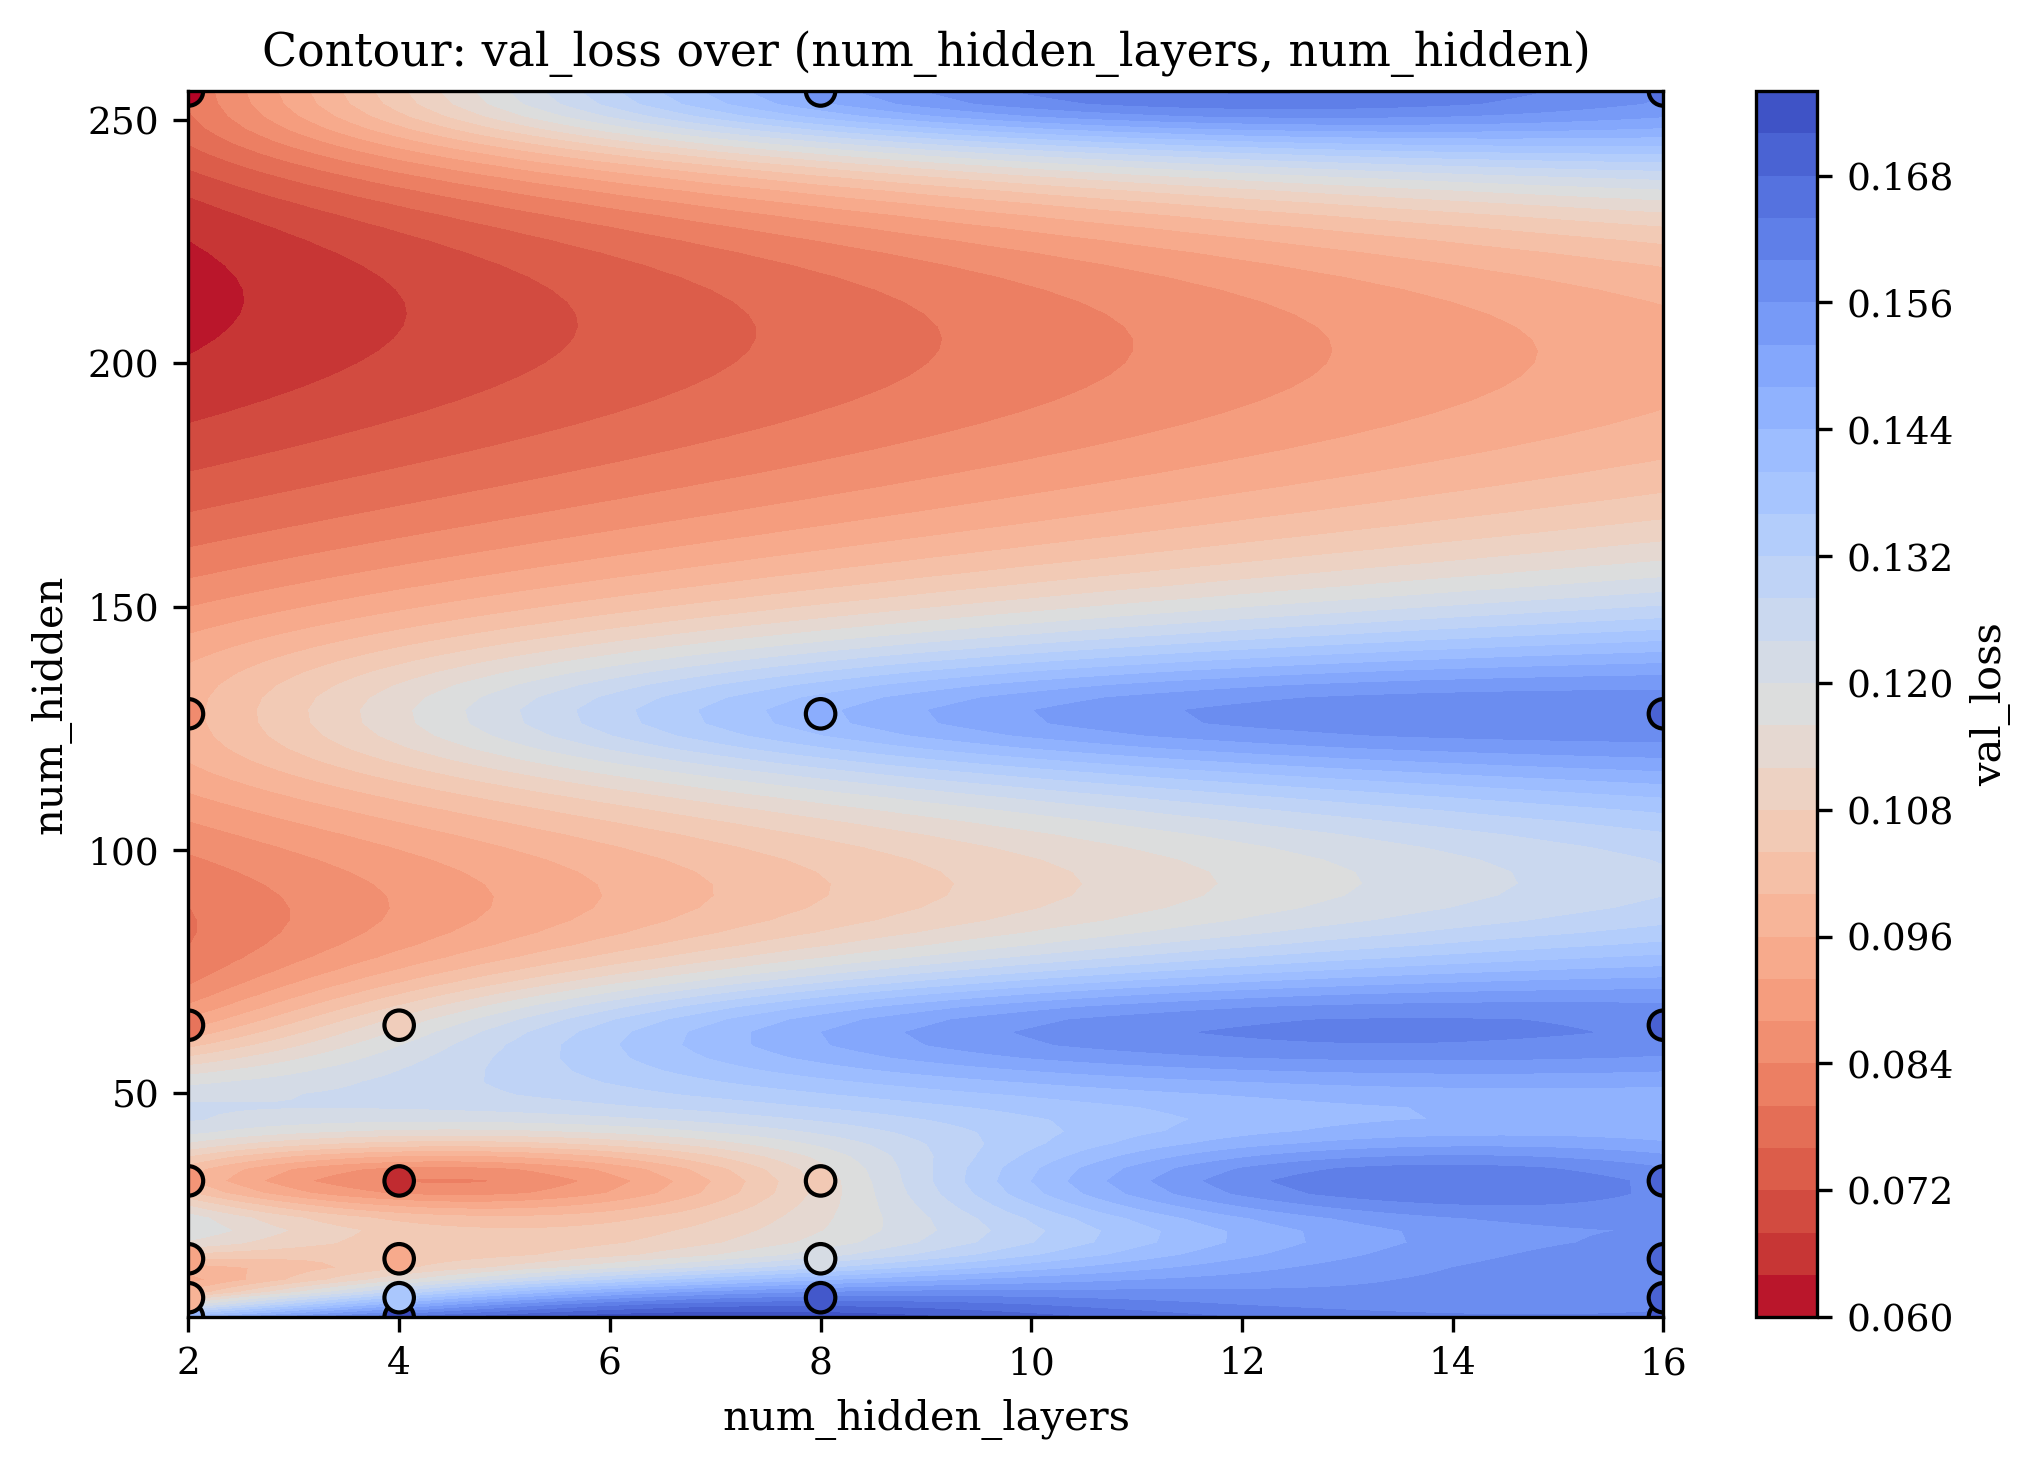

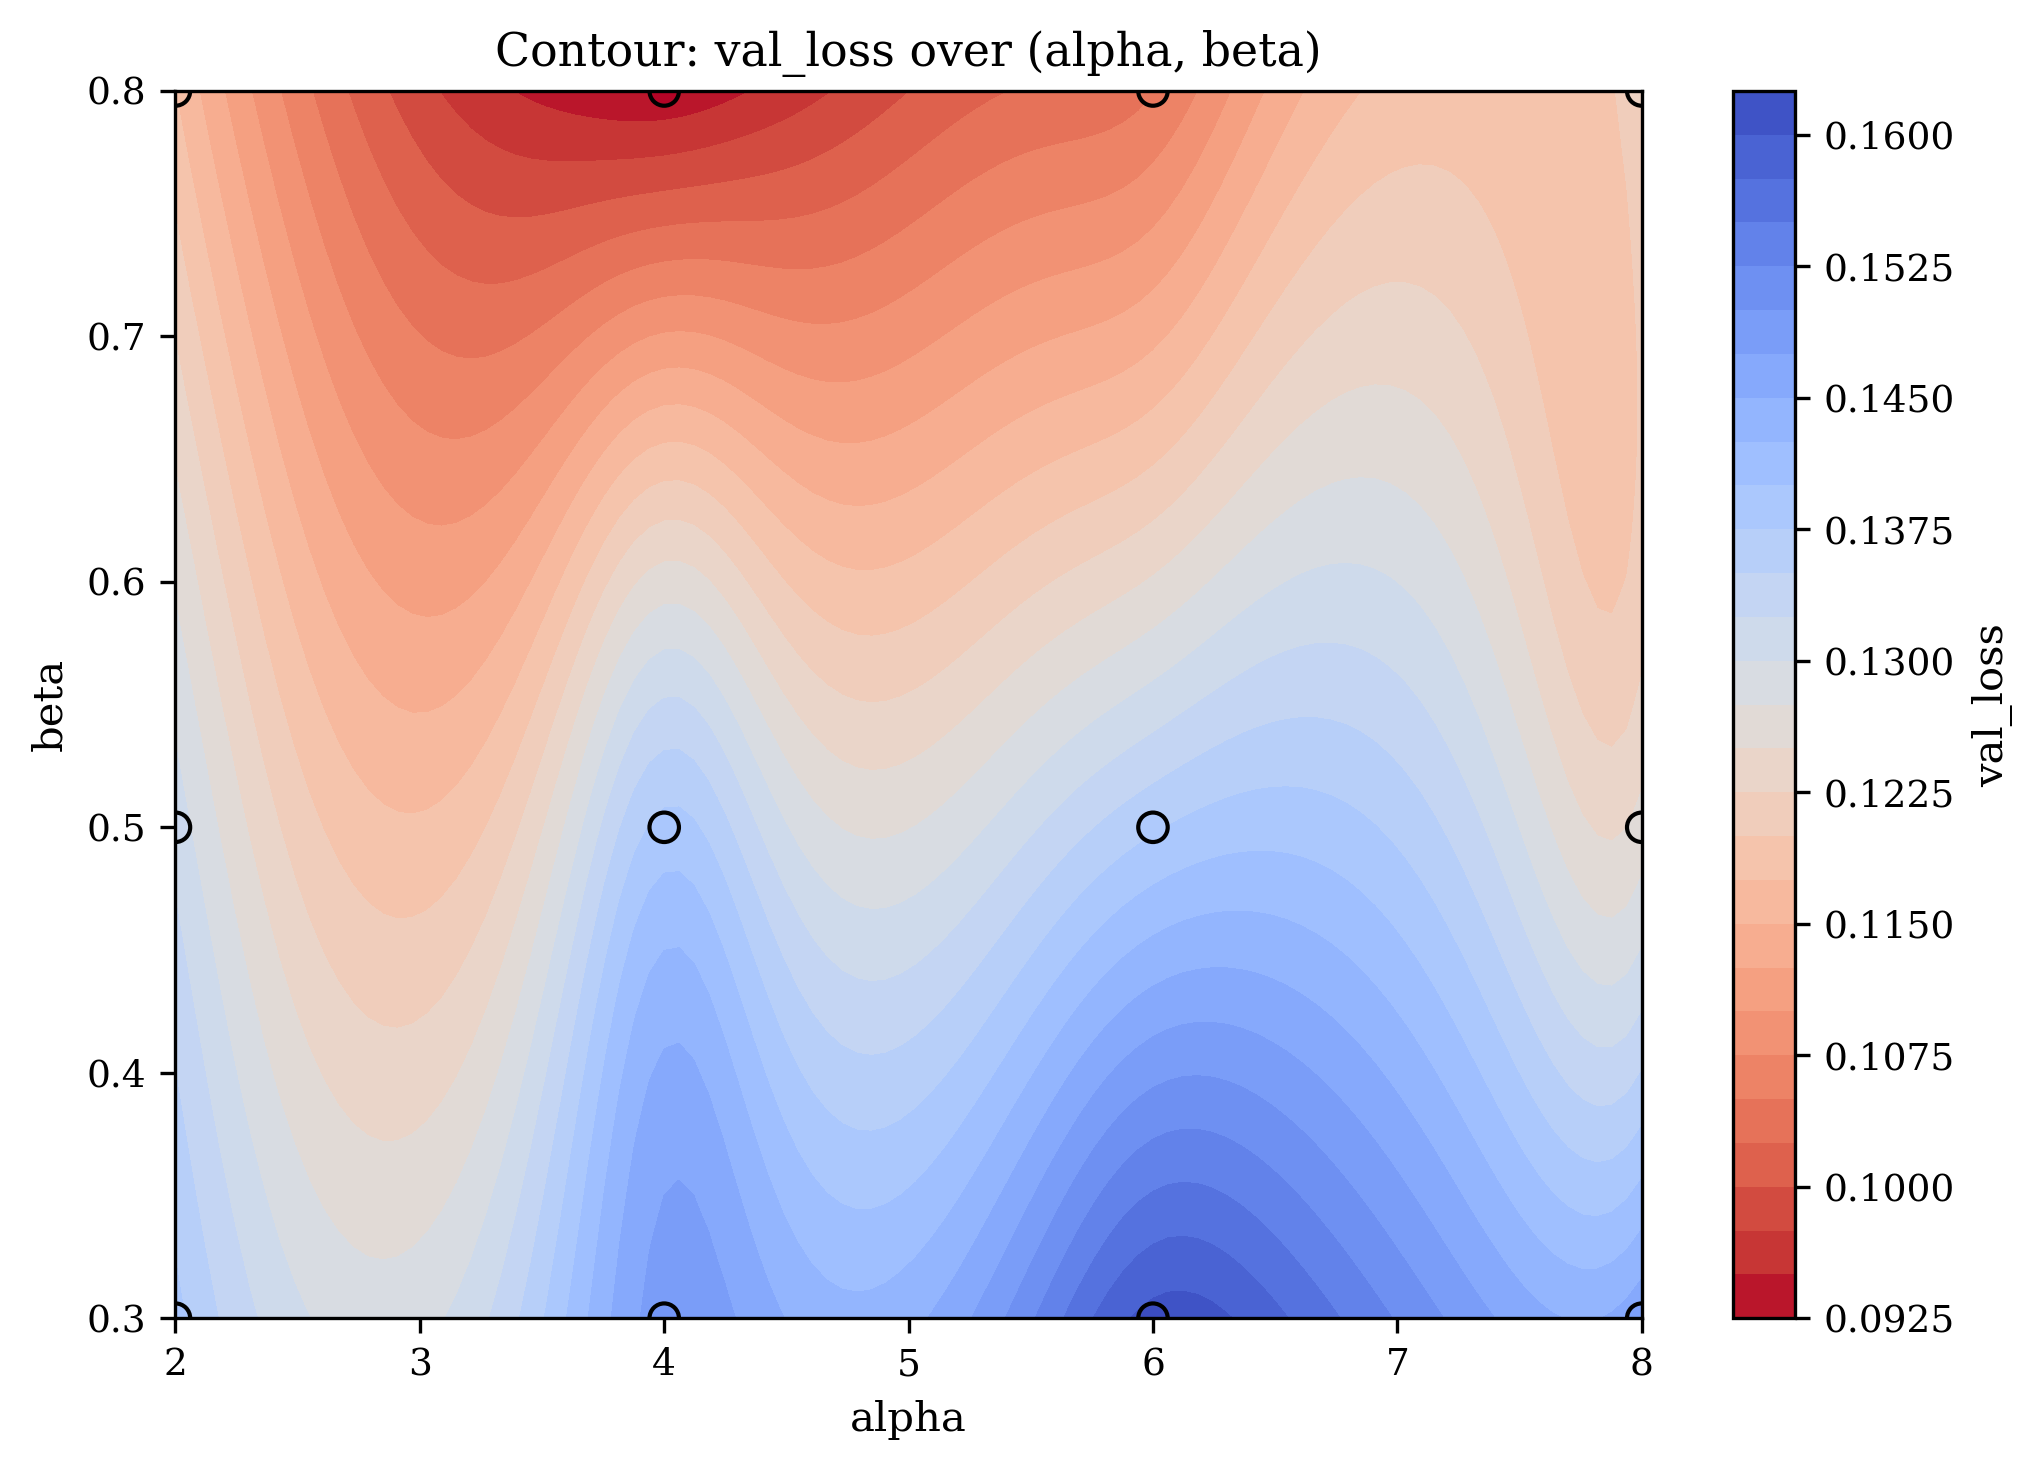

In [63]:
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------
# Extract val_loss from nested summary dictionary
# ----------------------------------------------------
df1["val_loss"] = df1["summary"].apply(lambda s: s.get("val_loss", np.nan))

# Drop any rows that do not have val_loss
df1_clean = df1.dropna(subset=["val_loss"])
df1_unique1 = df1_clean.groupby(["num_hidden_layers", "num_hidden"], as_index=False)["val_loss"].mean()
df1_unique2 = df1_clean.groupby(["alpha", "beta"], as_index=False)["val_loss"].mean()



# ----------------------------------------------------
# Helper function: create a contour plot
# ----------------------------------------------------
def contour_plot(df, x, y, z, title, name):
    X = df[x].values.astype(float)
    Y = df[y].values.astype(float)
    Z = df[z].values.astype(float)

    # Create grid for plotting
    xi = np.linspace(X.min(), X.max(), 100)
    yi = np.linspace(Y.min(), Y.max(), 100)
    XI, YI = np.meshgrid(xi, yi)

    # Interpolate using RBF
    rbf = Rbf(X, Y, Z, function='multiquadric')  # smooth RBF
    ZI = rbf(XI, YI)

    # Plot contour
    plt.figure(figsize=(7, 5))
    cp = plt.contourf(XI, YI, ZI, levels=30, cmap='coolwarm_r')
    plt.colorbar(cp, label=z)

    # Overlay original points
    plt.scatter(X, Y, c=Z, edgecolor='k', s=50,  cmap='coolwarm_r')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(name, bbox_inches="tight")
    plt.show()



# ----------------------------------------------------
# A. 
# ----------------------------------------------------
contour_plot(
    df1_unique1,
    x="num_hidden_layers",
    y="num_hidden",
    z="val_loss",
    title="Contour: val_loss over (num_hidden_layers, num_hidden)",
    name="hyperparamater_sweep_step1_contour_val_loss_over_layers_num_hidden.pdf"
)

# ----------------------------------------------------
# B. 
# ----------------------------------------------------
contour_plot(
    df1_unique2,
    x="alpha",
    y="beta",
    z="val_loss",
    title="Contour: val_loss over (alpha, beta)",
    name="hyperparamater_sweep_step1_contour_val_loss_over_alpha_beta.pdf"
)

### 2.3.2 Second Step: Optimizer

In [1]:
import wandb
import pandas as pd
import seaborn
import polars as ps
import matplotlib.pyplot as plt

In [2]:
wandb.login()

wandb: Currently logged in as: lupos to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [19]:
api = wandb.Api()

# Replace with your W&B entity/project
entity = "lupos"
project = "SpikeSynth-Surrogate-Sweep"
sweep_id = "n2edkczy"   

In [23]:
# Get the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

# Get all runs belonging to that sweep
runs = sweep.runs

# Collect run data
records = []
for run in sweep.runs:
    d = {
        "run_id": run.id,
        "name": run.name,
        "state": run.state,
        "summary": dict(run.summary),
    }
    # Flatten config into columns
    for k, v in run.config.items():
        if not k.startswith("_"):  # ignore internal W&B keys
            d[k] = v
    
    records.append(d)

# Create DataFrame
df2 = pd.DataFrame(records)

df2["val_loss"] = df2["summary"].apply(lambda s: s.get("val_loss", np.nan))
df2 = df2.dropna(subset=["val_loss"])

print(df2.head())

     run_id               name     state  \
0  9z3z9aib  visionary-sweep-1  finished   
1  7nns4m1c    logical-sweep-2  finished   
2  kcp78x6f     atomic-sweep-3  finished   
3  wb0aa66p       kind-sweep-4  finished   
4  runmjzt3      peach-sweep-5  finished   

                                             summary        lr           eps  \
0  {'_runtime': 837, '_step': 39, '_timestamp': 1...  0.007103  5.301737e-08   
1  {'_runtime': 177, '_step': 39, '_timestamp': 1...  0.000976  1.404193e-07   
2  {'_runtime': 159, '_step': 39, '_timestamp': 1...  0.000028  1.191996e-07   
3  {'_runtime': 191, '_step': 39, '_timestamp': 1...  0.006398  1.569883e-07   
4  {'_runtime': 212, '_step': 39, '_timestamp': 1...  0.007325  9.846984e-07   

   beta  alpha     beta1     beta2  ...  use_layernorm  bntt_time_steps  \
0   0.8      2  0.934309  0.998158  ...          False              100   
1   0.8      2  0.972155  0.984227  ...          False              100   
2   0.8      2  0.870431  0.9

In [5]:
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif"
})

/tmp/ipykernel_60742/3626625446.py:28: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



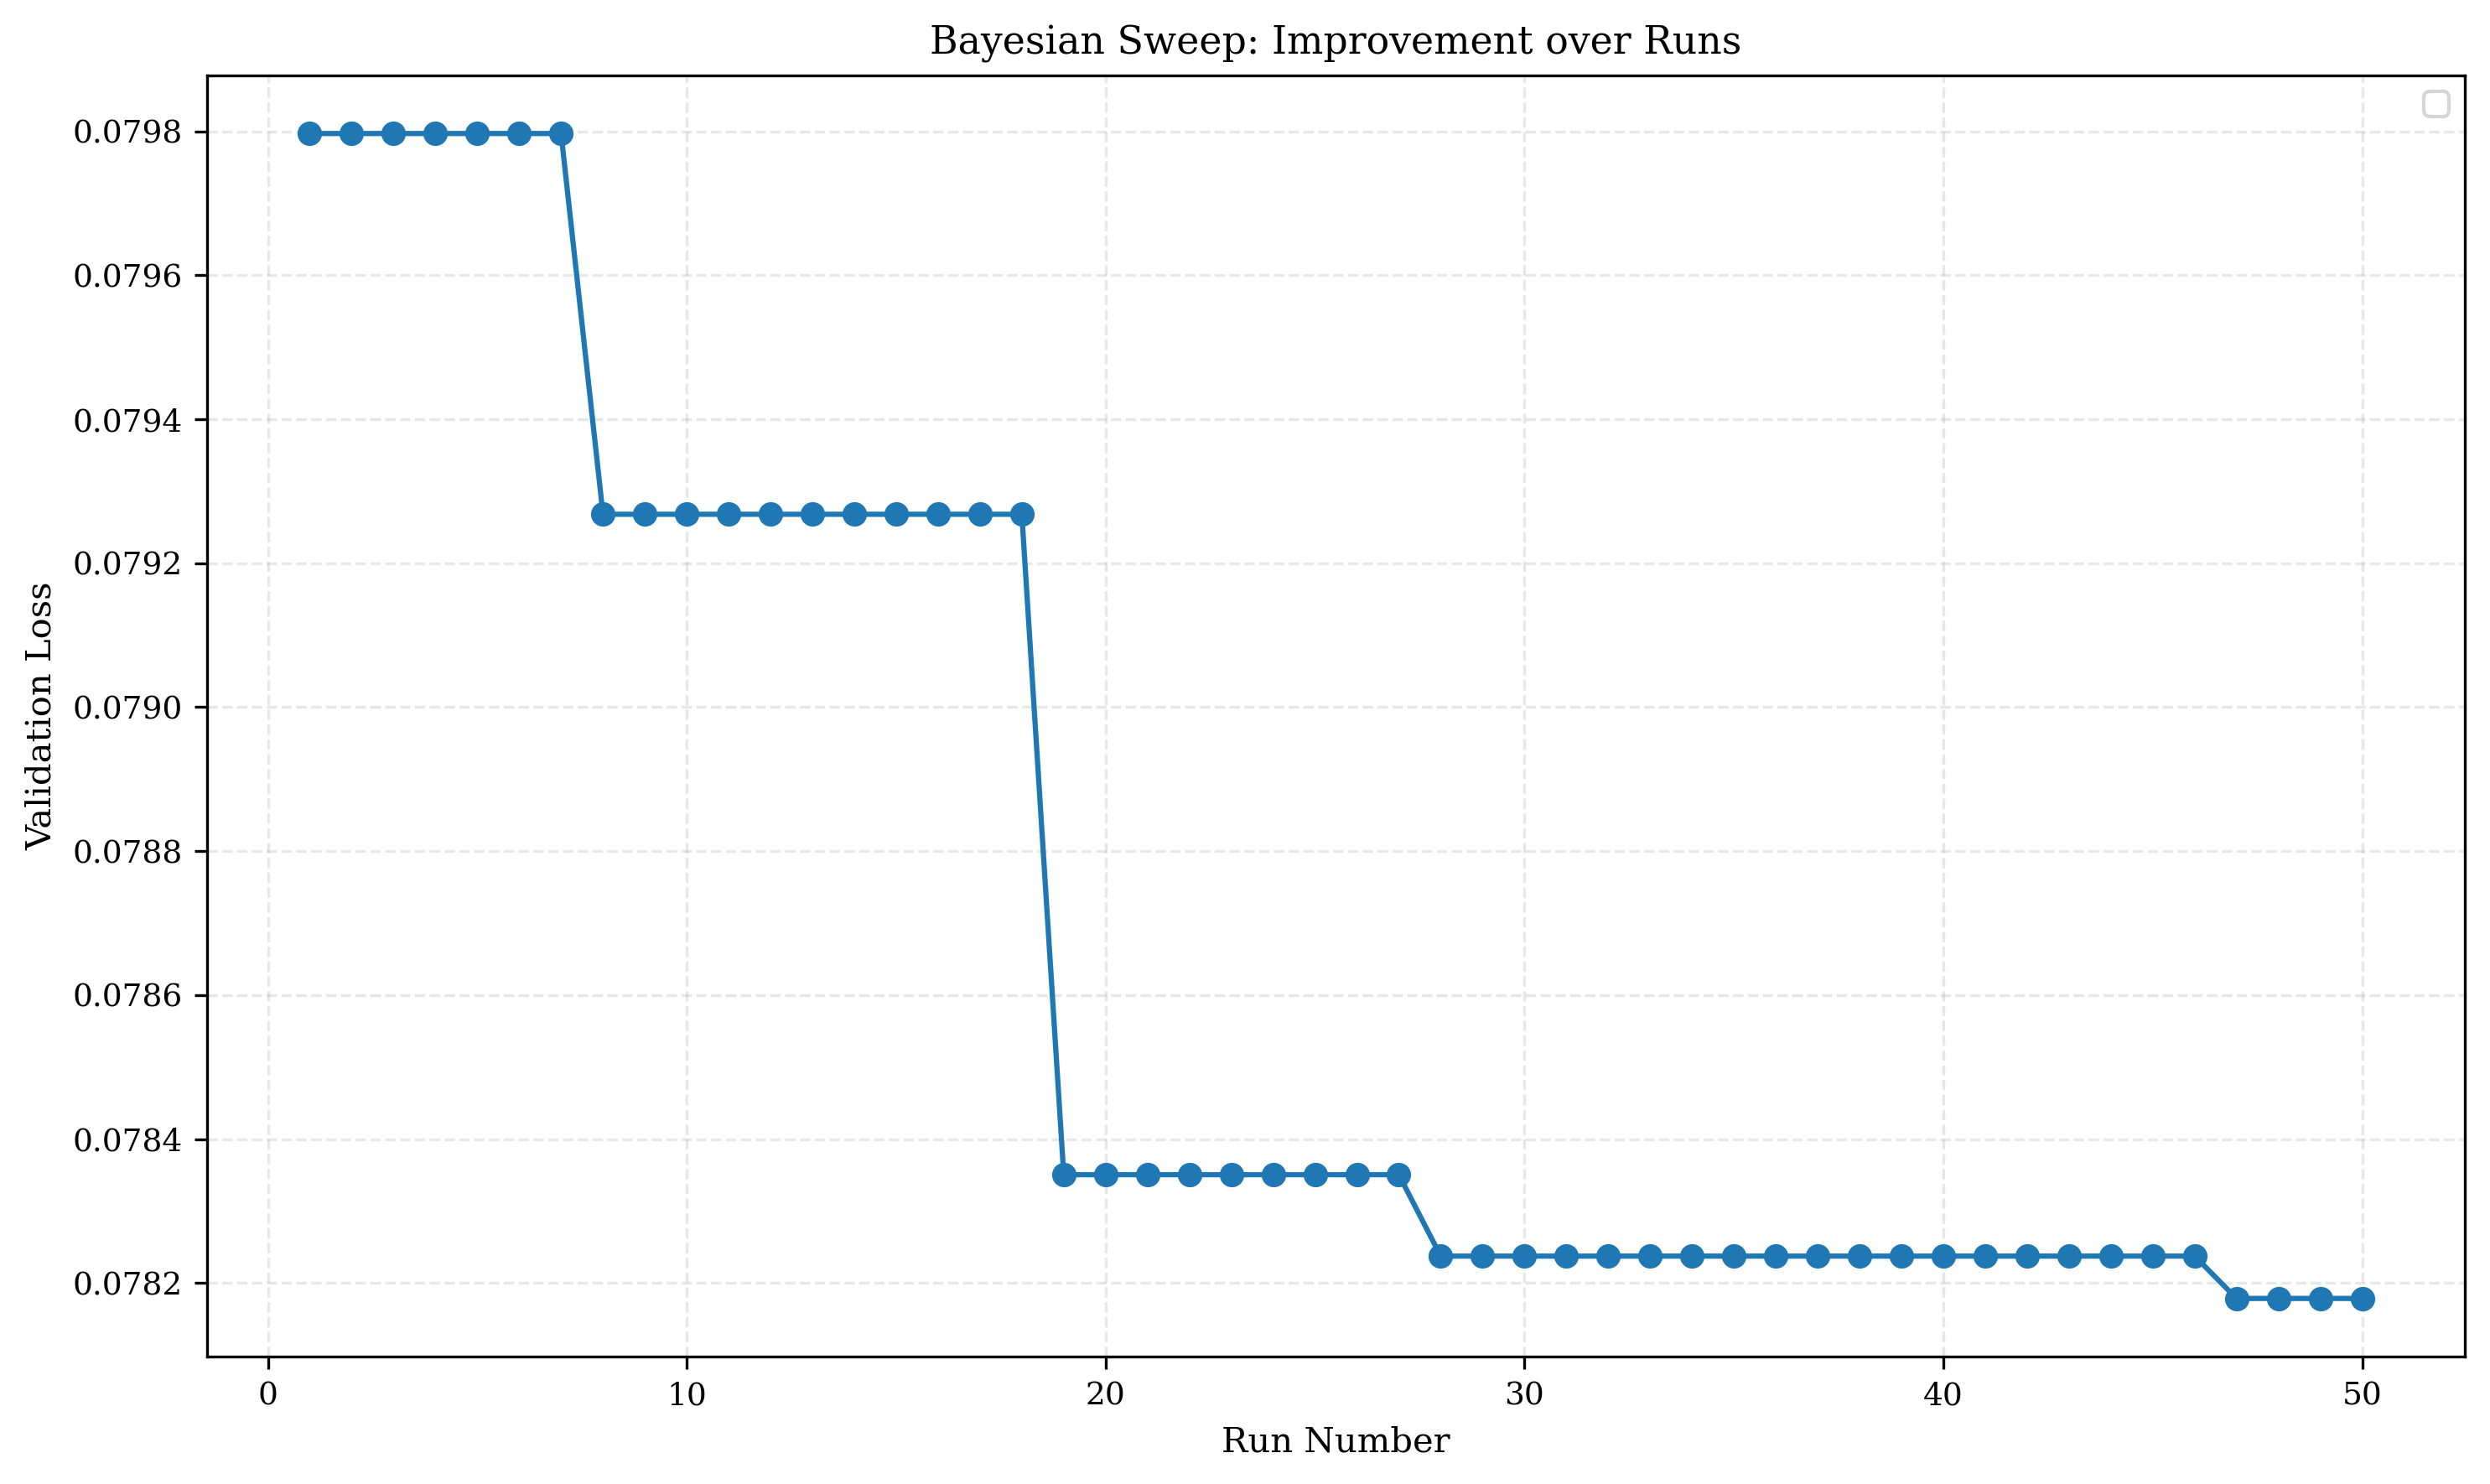

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------
# Extract val_loss from summary
# ----------------------------------------------------
df2["val_loss"] = df2["summary"].apply(lambda s: s.get("val_loss", np.nan))
df2 = df2.dropna(subset=["val_loss"])

# Sort runs by a proxy for time, e.g., 'run_id' or '_timestamp' if available
# Here we'll sort by W&B _step in summary, fallback to index
df2["_step"] = df2["summary"].apply(lambda s: s.get("_step", np.nan))
df2_sorted = df2.sort_values("_step").reset_index(drop=True)

# Compute cumulative minimum to track best val_loss over time
df2_sorted["best_val_loss"] = df2_sorted["val_loss"].cummin()

# ----------------------------------------------------
# Plot improvement over time
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df2_sorted.index + 1, df2_sorted["best_val_loss"], marker='o', linestyle='-', color='tab:blue')
# plt.scatter(df2_sorted.index + 1, df2_sorted["val_loss"], color='tab:orange', alpha=0.5, label='Current val_loss')
plt.xlabel("Run Number")
plt.ylabel("Validation Loss")
plt.title("Bayesian Sweep: Improvement over Runs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("hyperparameter_sweep_step2_improvement_bayesian.pdf", bbox_inches="tight")
plt.show()


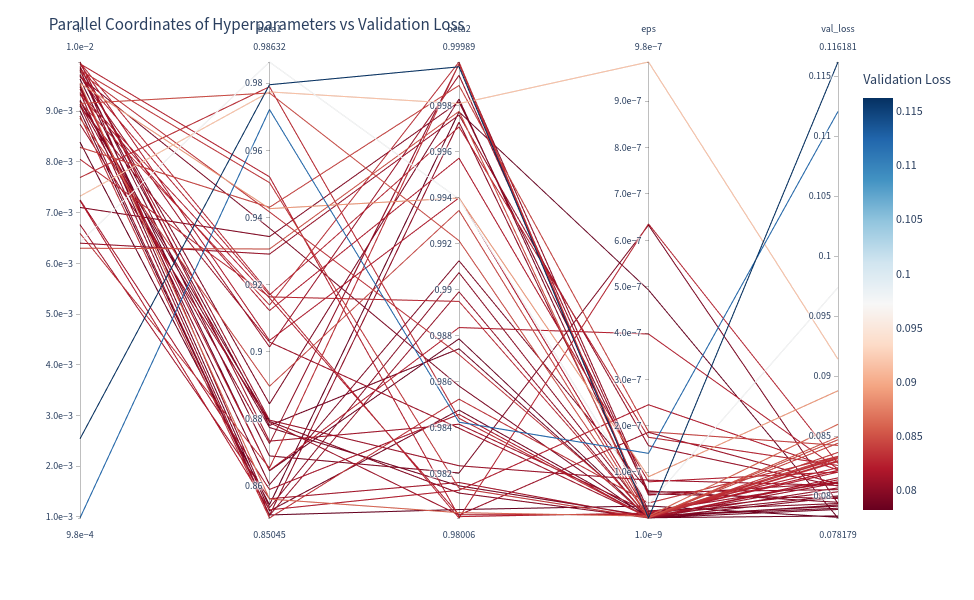

In [33]:
import plotly.express as px

df2_clean = df2[df2['val_loss'] < 0.2] 

# Make sure all hyperparameters and val_loss exist in df_plot
cols = ['lr', 'beta1', 'beta2', 'eps', 'val_loss']

fig = px.parallel_coordinates(
    df2_clean,
    dimensions=cols,
    color='val_loss',
    # Reverse color scale: RdBu instead of RdBu_r
    color_continuous_scale=px.colors.sequential.RdBu,
    labels={col: col for col in cols},
)

# Force scientific notation for val_loss (and eps if needed)
fig.update_layout(
    title="Parallel Coordinates: val_loss over all hyperparameters",
)

fig.update_coloraxes(colorbar_title="Validation Loss")

# Update axis tick formatting
for dim in fig.data[0]['dimensions']:
    if dim['label'] in ['eps', 'lr']:  # pick any small numbers you want scientific
        dim['tickformat'] = ".1e"  # scientific notation with 1 decimal

fig.update_layout(
    title="Parallel Coordinates of Hyperparameters vs Validation Loss",
    width=1200,
    height=600,
    font=dict(size=12)
)


fig.show()


In [36]:
import matplotlib.pyplot as plt
import matplotlib

# Get the colormap
cmap = plt.get_cmap("coolwarm", 256)

# Convert all 256 colors to HEX
hex_colors = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

# Print or use
print(hex_colors)


['#3b4cc0', '#3c4ec2', '#3d50c3', '#3e51c5', '#3f53c6', '#4055c8', '#4257c9', '#4358cb', '#445acc', '#455cce', '#465ecf', '#485fd1', '#4961d2', '#4a63d3', '#4b64d5', '#4c66d6', '#4e68d8', '#4f69d9', '#506bda', '#516ddb', '#536edd', '#5470de', '#5572df', '#5673e0', '#5875e1', '#5977e3', '#5a78e4', '#5b7ae5', '#5d7ce6', '#5e7de7', '#5f7fe8', '#6180e9', '#6282ea', '#6384eb', '#6485ec', '#6687ed', '#6788ee', '#688aef', '#6a8bef', '#6b8df0', '#6c8ff1', '#6e90f2', '#6f92f3', '#7093f3', '#7295f4', '#7396f5', '#7597f6', '#7699f6', '#779af7', '#799cf8', '#7a9df8', '#7b9ff9', '#7da0f9', '#7ea1fa', '#80a3fa', '#81a4fb', '#82a6fb', '#84a7fc', '#85a8fc', '#86a9fc', '#88abfd', '#89acfd', '#8badfd', '#8caffe', '#8db0fe', '#8fb1fe', '#90b2fe', '#92b4fe', '#93b5fe', '#94b6ff', '#96b7ff', '#97b8ff', '#98b9ff', '#9abbff', '#9bbcff', '#9dbdff', '#9ebeff', '#9fbfff', '#a1c0ff', '#a2c1ff', '#a3c2fe', '#a5c3fe', '#a6c4fe', '#a7c5fe', '#a9c6fd', '#aac7fd', '#abc8fd', '#adc9fd', '#aec9fc', '#afcafc', '#b1cbfc'

## 2.5 Compare Loss

In [37]:
import sys
import os

# Add the project root (one level above utils/)
sys.path.append(os.path.abspath("..")) 

from surrogate.utils.RSNN import SpikeSynth
from pytorch_lightning import Trainer
import wandb

In [38]:
api = wandb.Api()

# Replace with your W&B entity/project
runs = api.runs("lupos/surrogate-confidence")

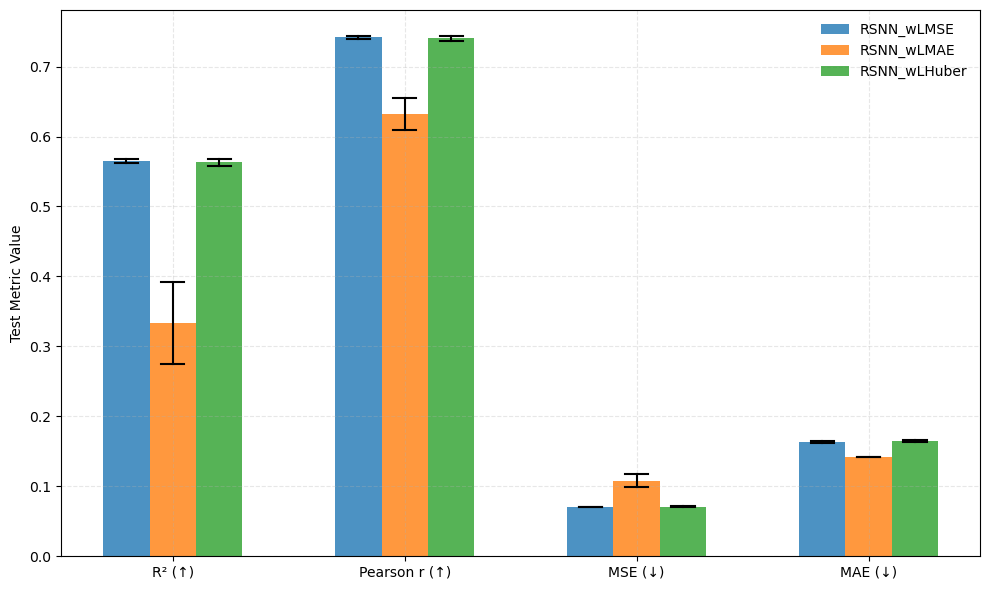

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.ticker import PercentFormatter

# Metrics to plot instead of layers
metric_cols = ["test_r2", "test_pearson", "test_mse", "test_mae"]

# Models (prefixes) to include
include = ["RSNN_wLMSE", "RSNN_wLMAE", "RSNN_wLHuber"]

grouped_data = []
for model_prefix in include:
    pattern = re.compile(f"^{re.escape(model_prefix)}_run")
    group = df[df["run_name"].str.match(pattern)]
    if len(group) == 0:
        continue

    # Last row of each run
    last_steps = group.groupby("run_name").tail(1)

    # Compute mean & std for the selected metrics
    means = last_steps[metric_cols].mean()
    stds = last_steps[metric_cols].std()

    # Keep only metrics present in the DF
    valid = means.notna()
    means = means[valid]
    stds = stds[valid]
    grouped_data.append((model_prefix, means, stds))

# Metric names and index positions
metric_names = grouped_data[0][1].index
metric_indices = np.arange(len(metric_names))

# Plot
n_models = len(grouped_data)
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.get_cmap("tab10").colors
offset = -width*(n_models-1)/2

for i, (model_name, means, stds) in enumerate(grouped_data):
    positions = metric_indices + offset + i*width
    bars = ax.bar(positions, means.values, width=width,
                  color=colors[i % len(colors)], alpha=0.8, label=model_name)

    # Add std as vertical line + caps
    for x, m, s in zip(positions, means.values, stds.values):
        ax.plot([x, x], [m - s, m + s], color='black', lw=1.5)
        ax.plot([x - width/4, x + width/4], [m + s, m + s], color='black', lw=1.5)
        ax.plot([x - width/4, x + width/4], [m - s, m - s], color='black', lw=1.5)

# X-axis labels (just metrics)
ax.set_xticks(metric_indices)
ax.set_xticklabels(metric_names)

ax.set_ylabel("Test Metric Value")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(frameon=False)

pretty_names = {
    "test_r2": "R² (↑)",
    "test_pearson": "Pearson r (↑)",
    "test_mse": "MSE (↓)",
    "test_mae": "MAE (↓)",
}

ax.set_xticks(metric_indices)
ax.set_xticklabels([pretty_names[m] for m in metric_names])

plt.tight_layout()
plt.savefig("spike_activity_test_metrics.pdf", bbox_inches="tight")
plt.show()


In [39]:
import re
import numpy as np
import pandas as pd

# metrics & models (use your existing lists if you prefer)
metric_cols = ["test_r2", "test_pearson", "test_mse", "test_mae"]
include = ["RSNN_wLMSE", "RSNN_wLMAE", "RSNN_wLHuber"]

# build summary rows like in your original code
rows = []
for model_prefix in include:
    pattern = re.compile(f"^{re.escape(model_prefix)}_run")
    group = df[df["run_name"].str.match(pattern)]
    if len(group) == 0:
        # skip if no runs found
        continue

    last_steps = group.groupby("run_name").tail(1)
    means = last_steps[metric_cols].mean()
    stds  = last_steps[metric_cols].std()

    # ensure all metrics exist (fill missing with NaN)
    row = {"model": model_prefix}
    for m in metric_cols:
        row[f"{m}_mean"] = means.get(m, np.nan)
        row[f"{m}_std"]  = stds.get(m, np.nan)
    rows.append(row)

# DataFrame of summary statistics
summary = pd.DataFrame(rows).set_index("model")

if summary.empty:
    print("No matching runs found for the requested models.")
else:
    # Rank R2 and Pearson: higher is better -> ascending=False
    # method='min' gives best performers the lowest integer rank (1 = best)
    summary["rank_r2"] = summary["test_r2_mean"].rank(ascending=False, method="min")
    summary["rank_pearson"] = summary["test_pearson_mean"].rank(ascending=False, method="min")

    # score_1 as requested:
    summary["score_1"] = summary["rank_r2"] + summary["rank_pearson"]

    # sort by score_1 (lower = better)
    summary = summary.sort_values("score_1")

    # print nicely: mean ± std for each metric, then ranks and score
    pd.set_option("display.width", 120)
    for model, r in summary.iterrows():
        print(f"Model: {model}    (score_1 = {int(r['score_1'])})")
        for m in metric_cols:
            mean = r[f"{m}_mean"]
            std  = r[f"{m}_std"]
            if pd.isna(mean):
                print(f"  {m:12}:  --")
            else:
                # choose sensible formatting; 4 decimals is usually OK for metrics
                print(f"  {m:12}:  {mean:.4f} ± {std:.4f}")
        # ranks (guard against NaN ranks)
        rr = int(r["rank_r2"]) if not pd.isna(r["rank_r2"]) else "NA"
        rp = int(r["rank_pearson"]) if not pd.isna(r["rank_pearson"]) else "NA"
        print(f"  rank(R2) = {rr}, rank(Pearson) = {rp}")
        print("-" * 60)

    # also print compact final table
    print("\nFinal ranking (best first):")
    print(summary[["rank_r2", "rank_pearson", "score_1"]].astype(int))


Model: RSNN_wLMSE    (score_1 = 2)
  test_r2     :  0.5656 ± 0.0027
  test_pearson:  0.7417 ± 0.0019
  test_mse    :  0.0706 ± 0.0004
  test_mae    :  0.1638 ± 0.0014
  rank(R2) = 1, rank(Pearson) = 1
------------------------------------------------------------
Model: RSNN_wLHuber    (score_1 = 4)
  test_r2     :  0.5633 ± 0.0050
  test_pearson:  0.7402 ± 0.0034
  test_mse    :  0.0710 ± 0.0008
  test_mae    :  0.1647 ± 0.0017
  rank(R2) = 2, rank(Pearson) = 2
------------------------------------------------------------
Model: RSNN_wLMAE    (score_1 = 6)
  test_r2     :  0.3335 ± 0.0587
  test_pearson:  0.6326 ± 0.0228
  test_mse    :  0.1083 ± 0.0095
  test_mae    :  0.1421 ± 0.0005
  rank(R2) = 3, rank(Pearson) = 3
------------------------------------------------------------

Final ranking (best first):
              rank_r2  rank_pearson  score_1
model                                       
RSNN_wLMSE          1             1        2
RSNN_wLHuber        2             2        4
RSN

## Visualize SRC

In [3]:
import math
from typing import Optional, Tuple

import torch
import torch.nn as nn
from torch import Tensor


class _StraightThroughReLU(torch.autograd.Function):
    """ReLU forward, but backward returns gradient * identity (pass-through).

    Forward: out = max(h, 0)
    Backward: grad_h = grad_output * 1  (for all h)
    """

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        # Pass gradients through unchanged (straight-through estimator)
        grad_input = grad_output.clone()
        return grad_input


class SRC(nn.Module):
    """Spiking Recurrent Cell (SRC) layer.

    This module processes a sequence of input pulses and returns the sequence of
    output pulses (sout) together with the final states (i, h, hs).
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        *,
        alpha: float = 0.9,
        rho: float = 3.0,
        r: float = 2.0,
        rs: float = -7.0,
        z: float = 0.0,
        zhyp_s: float = 0.9,
        zdep_s: float = 0.0,
        bh_init: float = -6.0,
        bh_max: float = -4.0,
        detach_rec: bool = True,
        relu_bypass: bool = True,
    ):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Learnable weights
        self.Ws = nn.Parameter(torch.empty(hidden_size, input_size))
        nn.init.kaiming_uniform_(self.Ws, a=math.sqrt(5))

        # Learnable bias bh (clamped at forward time)
        self.bh = nn.Parameter(torch.full((hidden_size,), bh_init))
        self.bh_max = float(bh_max)

        # Fixed hyper-parameters (not learnable)
        self.register_buffer("alpha", torch.tensor(float(alpha)))
        self.rho = float(rho)
        self.r = float(r)
        self.rs = float(rs)
        self.z = float(z)
        self.zhyp_s = float(zhyp_s)
        self.zdep_s = float(zdep_s)

        # Behavior flags
        self.detach_rec = bool(detach_rec)
        self.relu_bypass = bool(relu_bypass)

        # choose ReLU autograd behavior
        if self.relu_bypass:
            self._relu = _StraightThroughReLU.apply
        else:
            self._relu = torch.relu

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.Ws, a=math.sqrt(5))
        with torch.no_grad():
            self.bh.fill_(-6.0)

    def forward(self, sin: Tensor, states: Optional[Tuple[Tensor, Tensor, Tensor]] = None):
        """Forward pass over a sequence.

        Args:
            sin: Tensor with shape (seq_len, batch, input_size)
            states: optional tuple (i0, h0, hs0) each (batch, hidden_size). If
                    None they are initialized to zeros.

        Returns:
            sout: (seq_len, batch, hidden_size) spike outputs (float tensor)
            (i, h, hs): final states (each (batch, hidden_size))
        """
        if sin.dim() != 3:
            raise ValueError("sin must have shape (seq_len, batch, input_size)")
        seq_len, batch, input_size = sin.shape
        if input_size != self.input_size:
            raise ValueError(f"Expected input_size={self.input_size}, got {input_size}")

        device = sin.device

        if states is None:
            i = torch.zeros(batch, self.hidden_size, device=device)
            h = torch.zeros(batch, self.hidden_size, device=device)
            hs = torch.zeros(batch, self.hidden_size, device=device)
        else:
            i, h, hs = states

        # clamp bias to be <= bh_max
        bh_clamped = torch.clamp(self.bh, max=self.bh_max)

        # pre-allocate outputs
        sout_seq = []

        for t in range(seq_len):
            sin_t = sin[t]  # (batch, input_size)

            # Integrator: i[t] = alpha * i[t-1] + Ws @ sin[t]
            # Ws is (hidden, input); we want (batch, hidden) result
            delta = torch.matmul(sin_t, self.Ws.t())  # (batch, hidden)
            i = self.alpha * i + delta

            # x[t] = rho * tanh(i / rho)
            x = self.rho * torch.tanh(i / self.rho)

            # detach recurrent states so gradients don't flow through them in time
            if self.detach_rec:
                h_prev = h.detach()
                hs_prev = hs.detach()
            else:
                h_prev = h
                hs_prev = hs

            # compute zs from previous h (voltage-dependent step)
            # zs = zhyp_s + (zdep_s - zhyp_s) * H(h_prev - 0.5)
            # H implemented as (h_prev > 0.5).float()
            H = (h_prev > 0.5).float()
            zs = self.zhyp_s + (self.zdep_s - self.zhyp_s) * H

            # candidate hidden state: h_candidate = tanh(x + r * h_prev + rs * hs_prev + bh)
            preact = x + self.r * h_prev + self.rs * hs_prev + bh_clamped
            h_candidate = torch.tanh(preact)

            # update h and hs
            h = self.z * h_prev + (1.0 - self.z) * h_candidate
            hs = zs * hs_prev + (1.0 - zs) * h_prev

            # output spikes (forward ReLU, backward either bypassed or normal)
            sout_t = self._relu(h)
            sout_seq.append(sout_t)

        sout = torch.stack(sout_seq, dim=0)
        return sout, (i, h, hs)

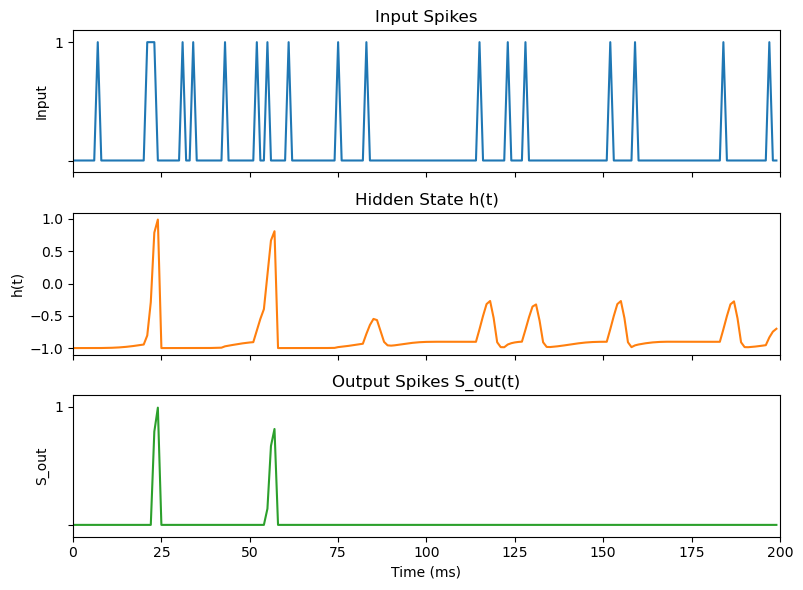

In [21]:
import torch
import matplotlib.pyplot as plt

# --- Simulation parameters ---
num_steps = 200
input_size = 1
hidden_size = 1  # for visualization simplicity

# --- Initialize SRC neuron ---
src = SRC(input_size=input_size, hidden_size=hidden_size)

# --- Generate input spikes ---
input_spikes = torch.zeros(num_steps, 1, input_size)  # (seq_len, batch, input_size)
input_spikes[10, 0, 0] = 1.0
input_spikes[80:100:5, 0, 0] = 1.0
input_spikes[120:128:2, 0, 0] = 1.0
input_spikes[140:148:4, 0, 0] = 1.0
input_spikes[160:168:4, 0, 0] = 1.0
input_spikes[180:188:4, 0, 0] = 1.0
input_spikes[195, 0, 0] = 1.0

# Automatic spikes
firing_rate = 0.1  # spikes per timestep
input_spikes = torch.bernoulli(firing_rate*torch.ones(num_steps, input_size))

# --- Initialize states ---
i = torch.zeros(1, hidden_size)
h = torch.zeros(1, hidden_size)
hs = torch.zeros(1, hidden_size)
bh_clamped = torch.clamp(src.bh, max=src.bh_max)


# --- Record states ---
h_rec = []
sout_rec = []

# --- Step through time manually ---
for t in range(num_steps):
    sin_t = input_spikes[t]

    # Integrator
    delta = torch.matmul(sin_t, src.Ws.t())
    i = src.alpha * i + delta
    x = src.rho * torch.tanh(i / src.rho)

    # Detach recurrent states for gradient flow
    h_prev = h.detach()
    hs_prev = hs.detach()

    # Compute voltage-dependent gate
    H = (h_prev > 0.5).float()
    zs = src.zhyp_s + (src.zdep_s - src.zhyp_s) * H

    # Candidate hidden state
    preact = x + src.r * h_prev + src.rs * hs_prev + bh_clamped
    h_candidate = torch.tanh(preact)

    # Update states
    h = src.z * h_prev + (1.0 - src.z) * h_candidate
    hs = zs * hs_prev + (1.0 - zs) * h_prev

    # Output spikes
    sout_t = src._relu(h)

    # Record
    h_rec.append(h.clone())
    sout_rec.append(sout_t.clone())

# Convert recordings to tensors for plotting
h_rec = torch.stack(h_rec).squeeze(1).squeeze(-1)
sout_rec = torch.stack(sout_rec).squeeze(1).squeeze(-1)
input_plot = input_spikes.squeeze(-1).squeeze(-1)

# --- Convert recordings to NumPy arrays for plotting ---
h_rec = h_rec.detach().cpu().numpy()
sout_rec = sout_rec.detach().cpu().numpy()
input_plot = input_plot.detach().cpu().numpy()

# --- Use default color cycle ---
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True)

# Input Spikes
ax[0].plot(input_plot, color=colors[0])
ax[0].set_title("Input Spikes")
ax[0].set_ylabel("Input")
ax[0].set_yticks([0, 1])
ax[0].set_yticklabels(['', '1'])
ax[0].set_xlim([0, num_steps])
ax[0].set_ylim([-0.1, 1.1])

# Hidden State
ax[1].plot(h_rec, color=colors[1])
ax[1].set_title("Hidden State h(t)")
ax[1].set_ylabel("h(t)")
ax[1].set_ylim([-1.1, 1.1])

# Output Spikes
ax[2].plot(sout_rec, color=colors[2])
ax[2].set_title("Output Spikes S_out(t)")
ax[2].set_xlabel("Time (ms)")
ax[2].set_ylabel("S_out")
ax[2].set_yticks([0, 1])
ax[2].set_yticklabels(['', '1'])
ax[2].set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()
fig.savefig("src_simulation.pdf", bbox_inches="tight")